<a href="https://colab.research.google.com/github/wannasmile/colab_code_note/blob/main/QUANT015.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')#
#!cp /content/drive/My\ Drive/##Colab\ Notebooks/CSV\ DT/* ##.

In [2]:
!pip install exchange_calendars lunarcalendar

In [3]:
!pip install pandas_ta

In [4]:
import pandas as pd  # 导入pandas库，用于数据处理
import numpy as np  # 导入numpy库，用于数值计算
import yfinance as yf  # 导入yfinance库，用于下载股票数据
from scipy.signal import find_peaks  # 导入find_peaks函数，用于查找峰值
import plotly.graph_objects as go  # 导入plotly.graph_objects库，用于创建图形对象
from plotly.subplots import make_subplots  # 导入make_subplots函数，用于创建子图

def download_data(ticker, start_date, end_date):
    """
    下载股票数据并处理多重索引

    参数：
    ticker (str): 股票代码
    start_date (str): 开始日期
    end_date (str): 结束日期

    返回：
    pandas.DataFrame: 股票数据
    """
    df = yf.download(ticker, start=start_date, end=end_date)  # 使用yfinance下载股票数据
    df.columns = df.columns.droplevel(1)  # 删除第二级索引(ticker名称)
    return df  # 返回处理后的数据

def find_elliott_waves(df, window=5, prominence=0.02):
    """
    识别艾略特波浪，包括主浪(1-5)和修正浪(a-b-c)

    参数：
    df (pandas.DataFrame): 股票数据
    window (int): 窗口大小，用于平滑数据
    prominence (float): 峰值突出度，用于识别重要峰值

    返回：
    list: 识别出的波浪列表
    """
    high_prices = df['High'].values.flatten()  # 获取最高价并转换为1维数组
    low_prices = df['Low'].values.flatten()  # 获取最低价并转换为1维数组
    close_prices = df['Close'].values.flatten()  # 获取收盘价并转换为1维数组

    high_prominence = prominence * np.mean(high_prices)  # 计算最高价的突出度阈值
    low_prominence = prominence * np.mean(low_prices)  # 计算最低价的突出度阈值

    peaks, _ = find_peaks(high_prices, prominence=high_prominence)  # 查找最高价的峰值
    valleys, _ = find_peaks(-low_prices, prominence=low_prominence)  # 查找最低价的谷值

    waves = []  # 初始化波浪列表

    all_points = np.sort(np.concatenate([peaks, valleys]))  # 合并峰值和谷值索引并排序

    for i in range(len(all_points) - 6):  # 遍历所有可能的波浪组合
        try:
            wave_points = all_points[i:i+7]  # 获取当前波浪的7个极值点

            point_types = []  # 初始化极值点类型列表
            for point in wave_points:  # 判断每个点是峰值还是谷值
                if point in peaks:
                    point_types.append('peak')
                else:
                    point_types.append('valley')

            wave_prices = [close_prices[point] for point in wave_points]  # 获取波浪的价格

            # 计算各个波浪的移动
            wave1_move = wave_prices[1] - wave_prices[0]  # 计算第一浪的移动
            wave2_move = wave_prices[2] - wave_prices[1]  # 计算第二浪的移动
            wave3_move = wave_prices[3] - wave_prices[2]  # 计算第三浪的移动
            wave4_move = wave_prices[4] - wave_prices[3]  # 计算第四浪的移动
            wave5_move = wave_prices[5] - wave_prices[4]  # 计算第五浪的移动
            wave_a_move = wave_prices[6] - wave_prices[5]  # 计算修正浪a的移动

            # 验证主浪规则
            impulse_wave_valid = (
                point_types[0] != point_types[1] and  # 相邻点必须是不同类型
                point_types[1] != point_types[2] and
                point_types[2] != point_types[3] and
                point_types[3] != point_types[4] and
                point_types[4] != point_types[5] and
                (abs(wave3_move) > abs(wave1_move) or  # 波浪3应该是较长的
                 abs(wave3_move) > abs(wave5_move)) and
                abs(wave2_move) < abs(wave3_move) and  # 波浪2和4的回调
                abs(wave2_move) <= 0.9 * abs(wave1_move)  # 波浪2不应回撤超过波浪1的起点
            )

            # 验证修正浪规则（简化版）
            corrective_wave_valid = (
                np.sign(wave_a_move) != np.sign(wave5_move)  # 确保修正浪的方向与主浪相反
            )

            if impulse_wave_valid and corrective_wave_valid:  # 如果主浪和修正浪都有效
                waves.append({  # 将波浪添加到列表中
                    'points': [df.index[p] for p in wave_points],  # 波浪的日期索引
                    'types': point_types,  # 波浪的类型（峰值或谷值）
                    'prices': wave_prices,  # 波浪的价格
                    'moves': {  # 波浪的移动
                        'wave1': wave1_move,
                        'wave2': wave2_move,
                        'wave3': wave3_move,
                        'wave4': wave4_move,
                        'wave5': wave5_move,
                        'wave_a': wave_a_move
                    }
                })

        except (IndexError, ValueError) as e:  # 异常处理
            continue

    filtered_waves = []  # 初始化过滤后的波浪列表
    for wave in waves:  # 遍历所有波浪
        overlap = False  # 初始化重叠标志
        for existing_wave in filtered_waves:  # 检查是否与已添加的波浪重叠
            if len(set(wave['points']) & set(existing_wave['points'])) > 3:  # 允许部分重叠
                overlap = True
                break
        if not overlap:  # 如果没有重叠，则添加到过滤后的列表
            filtered_waves.append(wave)

    return filtered_waves  # 返回过滤后的波浪列表

def visualize_waves(df, waves, ticker):
    """
    可视化艾略特波浪

    参数：
    df (pandas.DataFrame): 股票数据
    waves (list): 识别出的波浪列表
    ticker (str): 股票代码
    """
    fig = make_subplots(rows=2, cols=1,  # 创建2行1列的子图
                       row_heights=[0.7, 0.3],  # 设置行高比例
                       vertical_spacing=0.05,  # 设置垂直间距
                       subplot_titles=(f'{ticker} Elliott Waves', 'Volume'))  # 设置子图标题

    fig.add_trace(  # 添加K线图
        go.Candlestick(
            x=df.index,  # x轴为日期索引
            open=df['Open'],  # 开盘价
            high=df['High'],  # 最高价
            low=df['Low'],  # 最低价
            close=df['Close'],  # 收盘价
            name='K线'  # 图例名称
        ),
        row=1, col=1  # 添加到第一行第一列的子图
    )

    colors = ['red' if close >= open_ else 'green'  # 设置成交量柱状图颜色
             for close, open_ in zip(df['Close'], df['Open'])]

    fig.add_trace(  # 添加成交量柱状图
        go.Bar(
            x=df.index,  # x轴为日期索引
            y=df['Volume'],  # 成交量
            name='成交量',  # 图例名称
            marker_color=colors,  # 设置柱状图颜色
            opacity=0.5  # 设置透明度
        ),
        row=2, col=1  # 添加到第二行第一列的子图
    )

    wave_colors = ['rgba(255,0,0,0.8)', 'rgba(0,255,0,0.8)', 'rgba(0,0,255,0.8)', 'rgba(255,165,0,0.8)', 'rgba(128,0,128,0.8)']  # 设置波浪颜色

    for i, wave in enumerate(waves):  # 遍历所有波浪
        impulse_wave = {  # 设置主浪数据
            'x': wave['points'][:5],  # 主浪的日期索引
            'y': wave['prices'][:5],  # 主浪的价格
            'labels': ['1', '2', '3', '4', '5']  # 主浪的标签
        }

        fig.add_trace(  # 添加主浪线和标记
            go.Scatter(
                x=impulse_wave['x'],  # x轴为日期索引
                y=impulse_wave['y'],  # y轴为价格
                mode='lines+markers',  # 设置模式为线和标记
                name=f'主浪 {i+1}',  # 设置图例名称
                line=dict(color=wave_colors[i % len(wave_colors)], width=2),  # 设置线条颜色和宽度
                marker=dict(size=8, symbol='circle'),  # 设置标记大小和形状
                showlegend=True  # 显示图例
            ),
            row=1, col=1  # 添加到第一行第一列的子图
        )

        for point, price, label in zip(impulse_wave['x'],  # 添加主浪标注
                                     impulse_wave['y'],
                                     impulse_wave['labels']):
            y_offset = 40 if label in ['2', '4'] else -40  # 设置标注的y轴偏移量

            fig.add_annotation(  # 添加标注
                x=point,  # x轴位置
                y=price,  # y轴位置
                text=label,  # 标注文本
                showarrow=True,  # 显示箭头
                arrowhead=1,  # 设置箭头样式
                arrowsize=1,  # 设置箭头大小
                arrowwidth=2,  # 设置箭头宽度
                ax=0,  # 设置箭头偏移量
                ay=y_offset,  # 设置箭头偏移量
                font=dict(size=14, color="black"),  # 设置字体样式
                bgcolor="white",  # 设置背景颜色
                bordercolor="black",  # 设置边框颜色
                borderwidth=1,  # 设置边框宽度
                borderpad=4,  # 设置边框内边距
                opacity=0.8  # 设置透明度
            )

        if len(wave['points']) > 5:  # 如果有足够的点，添加修正浪
            corrective_wave = {  # 设置修正浪数据
                'x': wave['points'][4:],  # 修正浪的日期索引
                'y': wave['prices'][4:],  # 修正浪的价格
                'labels': ['a', 'b', 'c']  # 修正浪的标签
            }

            fig.add_trace(  # 添加修正浪线和标记
                go.Scatter(
                    x=corrective_wave['x'],  # x轴为日期索引
                    y=corrective_wave['y'],  # y轴为价格
                    mode='lines+markers',  # 设置模式为线和标记
                    name=f'修正浪 {i+1}',  # 设置图例名称
                    line=dict(color=wave_colors[(i+1) % len(wave_colors)],
                             width=2,
                             dash='dash'),  # 设置线条颜色、宽度和样式
                    marker=dict(size=8, symbol='square'),  # 设置标记大小和形状
                    showlegend=True  # 显示图例
                ),
                row=1, col=1  # 添加到第一行第一列的子图
            )

            for point, price, label in zip(corrective_wave['x'],  # 添加修正浪标注
                                         corrective_wave['y'],
                                         corrective_wave['labels']):
                y_offset = 40 if label in ['b'] else -40  # 设置标注的y轴偏移量

                fig.add_annotation(  # 添加标注
                    x=point,  # x轴位置
                    y=price,  # y轴位置
                    text=label,  # 标注文本
                    showarrow=True,  # 显示箭头
                    arrowhead=1,  # 设置箭头样式
                    arrowsize=1,  # 设置箭头大小
                    arrowwidth=2,  # 设置箭头宽度
                    ax=0,  # 设置箭头偏移量
                    ay=y_offset,  # 设置箭头偏移量
                    font=dict(size=14, color="black"),  # 设置字体样式
                    bgcolor="white",  # 设置背景颜色
                    bordercolor="black",  # 设置边框颜色
                    borderwidth=1,  # 设置边框宽度
                    borderpad=4,  # 设置边框内边距
                    opacity=0.8  # 设置透明度
                )

    fig.update_layout(  # 更新布局
        title=dict(  # 设置标题
            text=f"{ticker} 艾略特波浪分析",  # 设置标题文本
            x=0.5,  # 设置标题水平位置
            xanchor='center'  # 设置标题水平对齐方式
        ),
        yaxis_title="价格",  # 设置y轴标题
        yaxis2_title="成交量",  # 设置第二个y轴标题
        xaxis_rangeslider_visible=False,  # 隐藏x轴滑动条
        height=800,  # 设置图形高度
        showlegend=True,  # 显示图例
        legend=dict(  # 设置图例位置
            yanchor="top",  # 设置图例y轴对齐方式
            y=0.99,  # 设置图例y轴位置
            xanchor="left",  # 设置图例x轴对齐方式
            x=0.01  # 设置图例x轴位置
        )
    )

    fig.update_xaxes(title_text="日期", row=2, col=1)  # 设置第二个x轴标题
    fig.update_yaxes(title_text="价格", row=1, col=1)  # 设置第一个y轴标题
    fig.update_yaxes(title_text="成交量", row=2, col=1)  # 设置第二个y轴标题

    fig.show()  # 显示图形

def main():
    ticker = 'AAPL'  # 设置股票代码
    start_date = '2020-01-01'  # 设置开始日期
    end_date = '2023-10-26'  # 设置结束日期

    df = download_data(ticker, start_date, end_date)  # 下载股票数据

    waves = find_elliott_waves(df, prominence=0.02)  # 识别艾略特波浪

    if len(waves) > 0:  # 如果找到波浪
        print(f"找到 {len(waves)} 个艾略特波浪形态")  # 打印找到的波浪数量
        visualize_waves(df, waves, ticker)  # 可视化结果
    else:  # 如果没有找到波浪
        print("未找到艾略特波浪形态")  # 打印未找到波浪

if __name__ == "__main__":
    main()  # 执行主函数

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


找到 8 个艾略特波浪形态


In [5]:
import pandas as pd  # 导入 pandas 库，用于数据处理
import numpy as np  # 导入 numpy 库，用于数值计算
import yfinance as yf  # 导入 yfinance 库，用于下载股票数据
from scipy.signal import find_peaks  # 导入 find_peaks 函数，用于查找峰值
import plotly.graph_objects as go  # 导入 plotly.graph_objects 库，用于创建图形对象
from plotly.subplots import make_subplots  # 导入 make_subplots 函数，用于创建子图

def download_data(ticker, start_date, end_date):
    """
    下载股票数据并处理多重索引

    参数：
    ticker (str): 股票代码
    start_date (str): 开始日期
    end_date (str): 结束日期

    返回：
    pandas.DataFrame: 股票数据
    """
    df = yf.download(ticker, start=start_date, end=end_date)  # 使用 yfinance 下载股票数据
    df.columns = df.columns.droplevel(1)  # 删除第二级索引(ticker 名称)
    return df  # 返回处理后的数据

def find_elliott_waves(df, window=5, prominence=0.02):
    """
    识别艾略特波浪，包括主浪(1-5)和修正浪(a-b-c)

    参数：
    df (pandas.DataFrame): 股票数据
    window (int): 窗口大小，用于平滑数据 (当前未使用)
    prominence (float): 峰值突出度，用于识别重要峰值

    返回：
    list: 识别出的波浪列表
    """
    high_prices = df['High'].values.flatten()  # 获取最高价并转换为一维数组
    low_prices = df['Low'].values.flatten()  # 获取最低价并转换为一维数组
    close_prices = df['Close'].values.flatten()  # 获取收盘价并转换为一维数组

    high_prominence = prominence * np.mean(high_prices)  # 计算最高价的突出度阈值
    low_prominence = prominence * np.mean(low_prices)  # 计算最低价的突出度阈值

    peaks, _ = find_peaks(high_prices, prominence=high_prominence)  # 查找最高价的峰值
    valleys, _ = find_peaks(-low_prices, prominence=low_prominence)  # 查找最低价的谷值

    waves = []  # 初始化波浪列表

    all_points = np.sort(np.concatenate([peaks, valleys]))  # 合并峰值和谷值索引并排序

    for i in range(len(all_points) - 6):  # 遍历所有可能的波浪组合 (需要至少7个点来构成1-5和a-b)
        try:
            wave_points = all_points[i:i+7]  # 获取当前波浪的7个极值点

            point_types = []  # 初始化极值点类型列表
            for point in wave_points:  # 判断每个点是峰值还是谷值
                if point in peaks:
                    point_types.append('peak')
                else:
                    point_types.append('valley')

            wave_prices = [close_prices[point] for point in wave_points]  # 获取波浪的价格

            wave1_move = wave_prices[1] - wave_prices[0]  # 计算第一浪的移动
            wave2_move = wave_prices[2] - wave_prices[1]  # 计算第二浪的移动
            wave3_move = wave_prices[3] - wave_prices[2]  # 计算第三浪的移动
            wave4_move = wave_prices[4] - wave_prices[3]  # 计算第四浪的移动
            wave5_move = wave_prices[5] - wave_prices[4]  # 计算第五浪的移动
            wave_a_move = wave_prices[6] - wave_prices[5]  # 计算修正浪 a 的移动

            impulse_wave_valid = (  # 验证主浪规则
                point_types[0] != point_types[1] and  # 相邻点必须是不同类型
                point_types[1] != point_types[2] and
                point_types[2] != point_types[3] and
                point_types[3] != point_types[4] and
                point_types[4] != point_types[5] and
                (abs(wave3_move) > abs(wave1_move) or  # 波浪 3 应该是较长的
                 abs(wave3_move) > abs(wave5_move)) and
                abs(wave2_move) < abs(wave3_move) and  # 波浪 2 和 4 的回调
                abs(wave2_move) <= 0.9 * abs(wave1_move)  # 波浪 2 不应回撤超过波浪 1 的起点
            )

            corrective_wave_valid = (  # 验证修正浪规则（简化版）
                np.sign(wave_a_move) != np.sign(wave5_move)  # 确保修正浪的方向与主浪相反
            )

            if impulse_wave_valid and corrective_wave_valid:  # 如果主浪和修正浪都有效
                waves.append({  # 将波浪添加到列表中
                    'points': [df.index[p] for p in wave_points],  # 波浪的日期索引
                    'types': point_types,  # 波浪的类型（峰值或谷值）
                    'prices': wave_prices,  # 波浪的价格
                    'moves': {  # 波浪的移动
                        'wave1': wave1_move,
                        'wave2': wave2_move,
                        'wave3': wave3_move,
                        'wave4': wave4_move,
                        'wave5': wave5_move,
                        'wave_a': wave_a_move
                    }
                })

        except (IndexError, ValueError) as e:  # 异常处理
            continue

    filtered_waves = []  # 初始化过滤后的波浪列表
    for wave in waves:  # 遍历所有波浪
        overlap = False  # 初始化重叠标志
        for existing_wave in filtered_waves:  # 检查是否与已添加的波浪重叠
            if len(set(wave['points']) & set(existing_wave['points'])) > 3:  # 允许部分重叠
                overlap = True
                break
        if not overlap:  # 如果没有重叠，则添加到过滤后的列表
            filtered_waves.append(wave)

    return filtered_waves  # 返回过滤后的波浪列表

def visualize_waves(df, waves, ticker):
    """
    可视化艾略特波浪

    参数：
    df (pandas.DataFrame): 股票数据
    waves (list): 识别出的波浪列表
    ticker (str): 股票代码
    """
    df['Volume'] = df['Volume'].astype(float) #确保成交量为数值类型
    avg_volume = df['Volume'].mean() # 计算平均成交量
    relative_volume = (df['Volume'] / avg_volume).values # 计算相对成交量，并转换为numpy数组

    fig = make_subplots(rows=2, cols=1,  # 创建 2 行 1 列的子图
                       row_heights=[0.7, 0.3],  # 设置行高比例
                       vertical_spacing=0.05,  # 设置垂直间距
                       subplot_titles=(f'{ticker} 艾略特波浪分析', '相对成交量'))  # 设置子图标题

    fig.add_trace(  # 添加 K 线图
        go.Candlestick(
            x=df.index,  # x 轴为日期索引
            open=df['Open'],  # 开盘价
            high=df['High'],  # 最高价
            low=df['Low'],  # 最低价
            close=df['Close'],  # 收盘价
            name='K线'  # 图例名称
        ),
        row=1, col=1  # 添加到第一行第一列的子图
    )

    df['Change'] = df['Close'] - df['Open'] # 计算涨跌

    fig.add_trace( # 添加成交量柱状图
        go.Bar(
            x=df.index, # x轴为日期索引
            y=relative_volume, # y轴为相对成交量
            name='成交量', # 图例名称
            marker=dict( # 设置柱状图颜色
                color=np.where(df['Change'].values >= 0, 'red', 'green'), # 根据涨跌设置颜色
                opacity=0.7 # 设置透明度
            ),
            hovertemplate='%{x|%Y-%m-%d}<br>' + # 设置鼠标悬停时的提示信息
                         '相对成交量: %{y:.2f}倍<br>' +
                         '实际成交量: %{text:,.0f}<extra></extra>',
            text=df['Volume'].values # 设置提示信息中显示的实际成交量
        ),
        row=2, col=1 # 添加到第二行第一列的子图
    )

    fig.add_trace( # 添加平均成交量线
        go.Scatter(
            x=[df.index[0], df.index[-1]], # x轴为起始和结束日期
            y=[1, 1], # y轴为1，表示平均成交量
            mode='lines', # 设置模式为线
            line=dict( # 设置线条样式
                color='rgba(128,128,128,0.5)', # 设置颜色
                width=1, # 设置宽度
                dash='dash' # 设置虚线样式
            ),
            name='平均成交量', # 图例名称
            showlegend=False # 不显示图例
        ),
        row=2, col=1 # 添加到第二行第一列的子图
    )

    wave_colors = ['rgba(255,0,0,0.8)', 'rgba(0,255,0,0.8)', 'rgba(0,0,255,0.8)',
                  'rgba(255,165,0,0.8)', 'rgba(128,0,128,0.8)'] # 设置波浪颜色

    for i, wave in enumerate(waves): # 遍历所有波浪
        impulse_wave = { # 设置主浪数据
            'x': wave['points'][:6], # 主浪的日期索引
            'y': wave['prices'][:6], # 主浪的价格
            'labels': ['1', '2', '3', '4', '5'] # 主浪的标签
        }

        fig.add_trace( # 添加主浪线
            go.Scatter(
                x=impulse_wave['x'], # x轴为日期索引
                y=impulse_wave['y'], # y轴为价格
                mode='lines', # 设置模式为线
                name=f'主浪 {i+1}', # 图例名称
                line=dict(color=wave_colors[i % len(wave_colors)], width=2), # 设置线条颜色和宽度
                showlegend=True # 显示图例
            ),
            row=1, col=1 # 添加到第一行第一列的子图
        )

        for j, (point, price) in enumerate(zip(impulse_wave['x'][:-1], # 添加主浪标注
                                             impulse_wave['y'][:-1])):
            y_offset = 40 if j+1 in [2, 4] else -40 # 设置标注的y轴偏移量

            fig.add_annotation( # 添加标注
                x=point, # x轴位置
                y=price, # y轴位置
                text=str(j+1), # 标注文本
                showarrow=True, # 显示箭头
                arrowhead=1, # 设置箭头样式
                arrowsize=1, # 设置箭头大小
                arrowwidth=2, # 设置箭头宽度
                ax=0, # 设置箭头偏移量
                ay=y_offset, # 设置箭头偏移量
                font=dict(size=14, color="black"), # 设置字体样式
                bgcolor="white", # 设置背景颜色
                bordercolor="black", # 设置边框颜色
                borderwidth=1, # 设置边框宽度
                borderpad=4, # 设置边框内边距
                opacity=0.8 # 设置透明度
            )

        if len(wave['points']) > 5: # 如果有足够的点，添加修正浪
            corrective_wave = { # 设置修正浪数据
                'x': wave['points'][5:], # 修正浪的日期索引
                'y': wave['prices'][5:], # 修正浪的价格
                'labels': ['a', 'b', 'c'] # 修正浪的标签
            }

            fig.add_trace( # 添加修正浪线
                go.Scatter(
                    x=corrective_wave['x'], # x轴为日期索引
                    y=corrective_wave['y'], # y轴为价格
                    mode='lines', # 设置模式为线
                    name=f'修正浪 {i+1}', # 图例名称
                    line=dict(color=wave_colors[(i+1) % len(wave_colors)],
                             width=2,
                             dash='dash'), # 设置线条颜色、宽度和虚线样式
                    showlegend=True # 显示图例
                ),
                row=1, col=1 # 添加到第一行第一列的子图
            )

            for j, (point, price, label) in enumerate(zip(corrective_wave['x'], # 添加修正浪标注
                                                        corrective_wave['y'],
                                                        corrective_wave['labels'])):
                y_offset = 40 if label == 'b' else -40 # 设置标注的y轴偏移量

                fig.add_annotation( # 添加标注
                    x=point, # x轴位置
                    y=price, # y轴位置
                    text=label, # 标注文本
                    showarrow=True, # 显示箭头
                    arrowhead=1, # 设置箭头样式
                    arrowsize=1, # 设置箭头大小
                    arrowwidth=2, # 设置箭头宽度
                    ax=0, # 设置箭头偏移量
                    ay=y_offset, # 设置箭头偏移量
                    font=dict(size=14, color="black"), # 设置字体样式
                    bgcolor="white", # 设置背景颜色
                    bordercolor="black", # 设置边框颜色
                    borderwidth=1, # 设置边框宽度
                    borderpad=4, # 设置边框内边距
                    opacity=0.8 # 设置透明度
                )

    fig.update_layout( # 更新布局
        title=dict( # 设置标题
            text=f"{ticker} 艾略特波浪分析", # 设置标题文本
            x=0.5, # 设置标题水平位置
            xanchor='center' # 设置标题水平对齐方式
        ),
        yaxis_title="价格", # 设置y轴标题
        xaxis_rangeslider_visible=False, # 隐藏x轴滑动条
        height=800, # 设置图形高度
        showlegend=True, # 显示图例
        legend=dict( # 设置图例位置
            yanchor="top", # 设置图例y轴对齐方式
            y=0.99, # 设置图例y轴位置
            xanchor="left", # 设置图例x轴对齐方式
            x=0.01 # 设置图例x轴位置
        ),
        margin=dict(l=50, r=50, t=50, b=50), # 设置边距
        bargap=0.2, # 调整柱状图间距
        bargroupgap=0.1 # 调整组内间距
    )

    fig.update_xaxes( # 更新第一个x轴格式
        title_text="日期", # 设置x轴标题
        type='date', # 设置x轴类型为日期
        tickformat='%Y-%m-%d', # 设置x轴刻度格式
        tickmode='auto', # 设置x轴刻度模式为自动
        nticks=10, # 设置x轴刻度数量
        row=1, col=1 # 设置x轴位置
    )

    fig.update_xaxes( # 更新第二个x轴格式
        title_text="日期", # 设置x轴标题
        type='date', # 设置x轴类型为日期
        tickformat='%Y-%m-%d', # 设置x轴刻度格式
        tickmode='auto', # 设置x轴刻度模式为自动
        nticks=10, # 设置x轴刻度数量
        row=2, col=1 # 设置x轴位置
    )

    fig.update_yaxes( # 更新第一个y轴格式
        title_text="价格", # 设置y轴标题
        row=1, col=1 # 设置y轴位置
    )

    y_max = float(np.max(relative_volume)) # 获取相对成交量的最大值

    fig.update_yaxes( # 更新第二个y轴格式
        title_text="相对成交量(倍)", # 设置y轴标题
        showticklabels=True, # 显示y轴刻度标签
        tickformat='.1f', # 设置y轴刻度格式
        row=2, col=1, # 设置y轴位置
        rangemode='nonnegative', # 确保y轴从0开始
        range=[0, y_max * 1.1] # 设置y轴范围
    )

    fig.update_xaxes(matches='x') # 确保两个子图的x轴范围一致

    fig.show() # 显示图形

def main():
    ticker = 'AAPL' # 设置股票代码
    start_date = '2020-01-01' # 设置开始日期
    end_date = '2023-10-26' # 设置结束日期

    df = download_data(ticker, start_date, end_date) # 下载股票数据

    waves = find_elliott_waves(df, prominence=0.02) # 识别艾略特波浪

    if len(waves) > 0: # 如果找到波浪
        print(f"找到 {len(waves)} 个艾略特波浪形态") # 打印找到的波浪数量
        visualize_waves(df, waves, ticker) # 可视化结果
    else: # 如果没有找到波浪
        print("未找到艾略特波浪形态") # 打印未找到波浪

if __name__ == "__main__":
    main() # 执行主函数

[*********************100%***********************]  1 of 1 completed


找到 8 个艾略特波浪形态


In [6]:
import pandas as pd  # 导入 pandas 库，用于数据处理
import numpy as np  # 导入 numpy 库，用于数值计算
import yfinance as yf  # 导入 yfinance 库，用于下载股票数据
from scipy.signal import find_peaks  # 导入 find_peaks 函数，用于查找峰值
import plotly.graph_objects as go  # 导入 plotly.graph_objects 库，用于创建图形对象
from plotly.subplots import make_subplots  # 导入 make_subplots 函数，用于创建子图

def download_data(ticker, start_date, end_date):
    """
    下载股票数据并处理多重索引

    参数：
    ticker (str): 股票代码
    start_date (str): 开始日期
    end_date (str): 结束日期

    返回：
    pandas.DataFrame: 股票数据
    """
    df = yf.download(ticker, start=start_date, end=end_date)  # 使用 yfinance 下载股票数据
    df.columns = df.columns.droplevel(1)  # 删除第二级索引(ticker 名称)
    return df  # 返回处理后的数据

def find_elliott_waves(df, window=5, prominence=0.02):
    """
    识别艾略特波浪，包括主浪(1-5)和修正浪(a-b-c)

    参数：
    df (pandas.DataFrame): 股票数据
    window (int): 窗口大小，用于判断趋势
    prominence (float): 峰值突出度，用于识别重要峰值

    返回：
    list: 识别出的波浪列表
    """
    high_prices = df['High'].values.flatten()
    low_prices = df['Low'].values.flatten()
    close_prices = df['Close'].values.flatten()

    high_prominence = prominence * np.mean(high_prices)
    low_prominence = prominence * np.mean(low_prices)

    peaks, _ = find_peaks(high_prices, prominence=high_prominence)
    valleys, _ = find_peaks(-low_prices, prominence=low_prominence)

    waves = []
    all_points = np.sort(np.concatenate([peaks, valleys]))

    def is_uptrend(wave_points, prices):
        """判断是否为上升趋势"""
        return prices[-1] > prices[0]

    def validate_elliott_wave(wave_points, prices, point_types, is_upward):
        """验证艾略特波浪规则"""
        # 计算各浪的移动幅度
        moves = []
        for i in range(len(prices)-1):
            moves.append(prices[i+1] - prices[i])

        wave1_move = abs(moves[0])
        wave2_move = abs(moves[1])
        wave3_move = abs(moves[2])
        wave4_move = abs(moves[3])
        wave5_move = abs(moves[4])

        if is_upward:
            # 上升趋势的规则验证
            return (
                # 第三浪不能最短
                wave3_move > wave1_move and wave3_move > wave5_move and
                # 第二浪不能回撤超过第一浪起点
                prices[2] > prices[0] and
                # 第四浪不能与第一浪重叠
                prices[4] > prices[1] and
                # 相邻波浪点必须交替出现峰谷
                all(point_types[i] != point_types[i+1] for i in range(len(point_types)-1)) and
                # 第二浪回撤不超过第一浪的90%
                wave2_move <= 0.9 * wave1_move
            )
        else:
            # 下降趋势的规则验证
            return (
                # 第三浪不能最短
                wave3_move > wave1_move and wave3_move > wave5_move and
                # 第二浪不能超过第一浪起点
                prices[2] < prices[0] and
                # 第四浪不能与第一浪重叠
                prices[4] < prices[1] and
                # 相邻波浪点必须交替出现峰谷
                all(point_types[i] != point_types[i+1] for i in range(len(point_types)-1)) and
                # 第二浪反弹不超过第一浪的90%
                wave2_move <= 0.9 * wave1_move
            )

    for i in range(len(all_points) - 6):
        try:
            wave_points = all_points[i:i+7]
            point_types = []
            for point in wave_points:
                if point in peaks:
                    point_types.append('peak')
                else:
                    point_types.append('valley')

            wave_prices = [close_prices[point] for point in wave_points]

            moves = []
            for k in range(len(wave_prices) - 1):
                moves.append(wave_prices[k + 1] - wave_prices[k])

            # 判断趋势方向
            is_upward = is_uptrend(wave_points, wave_prices)

            # 验证主浪规则
            impulse_wave_valid = validate_elliott_wave(
                wave_points[:6],
                wave_prices[:6],
                point_types[:6],
                is_upward
            )

            # 验证修正浪规则
            if len(wave_points) > 6:
                wave_a_move = wave_prices[6] - wave_prices[5]
                corrective_wave_valid = (
                    # 修正浪方向与主浪相反
                    (is_upward and wave_a_move < 0) or
                    (not is_upward and wave_a_move > 0)
                )
            else:
                corrective_wave_valid = True

            if impulse_wave_valid and corrective_wave_valid:
                waves.append({
                    'points': [df.index[p] for p in wave_points],
                    'types': point_types,
                    'prices': wave_prices,
                    'is_upward': is_upward,
                    'moves': {
                        'wave1': moves[0],
                        'wave2': moves[1],
                        'wave3': moves[2],
                        'wave4': moves[3],
                        'wave5': moves[4],
                        'wave_a': wave_a_move if len(moves) > 5 else None
                    }
                })

        except (IndexError, ValueError) as e:
            continue

    # 过滤重叠的波浪
    filtered_waves = []
    for wave in waves:
        overlap = False
        for existing_wave in filtered_waves:
            if len(set(wave['points']) & set(existing_wave['points'])) > 3:
                overlap = True
                break
        if not overlap:
            filtered_waves.append(wave)

    return filtered_waves

def visualize_waves(df, waves, ticker):
    """
    可视化艾略特波浪

    参数：
    df (pandas.DataFrame): 股票数据
    waves (list): 识别出的波浪列表
    ticker (str): 股票代码
    """
    df['Volume'] = df['Volume'].astype(float) #确保成交量为数值类型
    avg_volume = df['Volume'].mean() # 计算平均成交量
    relative_volume = (df['Volume'] / avg_volume).values # 计算相对成交量，并转换为numpy数组

    fig = make_subplots(rows=2, cols=1,  # 创建 2 行 1 列的子图
                       row_heights=[0.7, 0.3],  # 设置行高比例
                       vertical_spacing=0.05,  # 设置垂直间距
                       subplot_titles=(f'{ticker} 艾略特波浪分析', '相对成交量'))  # 设置子图标题

    fig.add_trace(  # 添加 K 线图
        go.Candlestick(
            x=df.index,  # x 轴为日期索引
            open=df['Open'],  # 开盘价
            high=df['High'],  # 最高价
            low=df['Low'],  # 最低价
            close=df['Close'],  # 收盘价
            name='K线'  # 图例名称
        ),
        row=1, col=1  # 添加到第一行第一列的子图
    )

    df['Change'] = df['Close'] - df['Open'] # 计算涨跌

    fig.add_trace( # 添加成交量柱状图
        go.Bar(
            x=df.index, # x轴为日期索引
            y=relative_volume, # y轴为相对成交量
            name='成交量', # 图例名称
            marker=dict( # 设置柱状图颜色
                color=np.where(df['Change'].values >= 0, 'red', 'green'), # 根据涨跌设置颜色
                opacity=0.7 # 设置透明度
            ),
            hovertemplate='%{x|%Y-%m-%d}<br>' + # 设置鼠标悬停时的提示信息
                         '相对成交量: %{y:.2f}倍<br>' +
                         '实际成交量: %{text:,.0f}<extra></extra>',
            text=df['Volume'].values # 设置提示信息中显示的实际成交量
        ),
        row=2, col=1 # 添加到第二行第一列的子图
    )

    fig.add_trace( # 添加平均成交量线
        go.Scatter(
            x=[df.index[0], df.index[-1]], # x轴为起始和结束日期
            y=[1, 1], # y轴为1，表示平均成交量
            mode='lines', # 设置模式为线
            line=dict( # 设置线条样式
                color='rgba(128,128,128,0.5)', # 设置颜色
                width=1, # 设置宽度
                dash='dash' # 设置虚线样式
            ),
            name='平均成交量', # 图例名称
            showlegend=False # 不显示图例
        ),
        row=2, col=1 # 添加到第二行第一列的子图
    )

    wave_colors = ['rgba(255,0,0,0.8)', 'rgba(0,255,0,0.8)', 'rgba(0,0,255,0.8)',
                  'rgba(255,165,0,0.8)', 'rgba(128,0,128,0.8)'] # 设置波浪颜色

    for i, wave in enumerate(waves): # 遍历所有波浪
        impulse_wave = { # 设置主浪数据
            'x': wave['points'][:6], # 主浪的日期索引
            'y': wave['prices'][:6], # 主浪的价格
            'labels': ['1', '2', '3', '4', '5'] # 主浪的标签
        }

        fig.add_trace( # 添加主浪线
            go.Scatter(
                x=impulse_wave['x'], # x轴为日期索引
                y=impulse_wave['y'], # y轴为价格
                mode='lines', # 设置模式为线
                name=f'主浪 {i+1}', # 图例名称
                line=dict(color=wave_colors[i % len(wave_colors)], width=2), # 设置线条颜色和宽度
                showlegend=True # 显示图例
            ),
            row=1, col=1 # 添加到第一行第一列的子图
        )

        for j, (point, price) in enumerate(zip(impulse_wave['x'][:-1], # 添加主浪标注
                                             impulse_wave['y'][:-1])):
            y_offset = 40 if j+1 in [2, 4] else -40 # 设置标注的y轴偏移量

            fig.add_annotation( # 添加标注
                x=point, # x轴位置
                y=price, # y轴位置
                text=str(j+1), # 标注文本
                showarrow=True, # 显示箭头
                arrowhead=1, # 设置箭头样式
                arrowsize=1, # 设置箭头大小
                arrowwidth=2, # 设置箭头宽度
                ax=0, # 设置箭头偏移量
                ay=y_offset, # 设置箭头偏移量
                font=dict(size=14, color="black"), # 设置字体样式
                bgcolor="white", # 设置背景颜色
                bordercolor="black", # 设置边框颜色
                borderwidth=1, # 设置边框宽度
                borderpad=4, # 设置边框内边距
                opacity=0.8 # 设置透明度
            )

        if len(wave['points']) > 5: # 如果有足够的点，添加修正浪
            corrective_wave = { # 设置修正浪数据
                'x': wave['points'][5:], # 修正浪的日期索引
                'y': wave['prices'][5:], # 修正浪的价格
                'labels': ['a', 'b', 'c'] # 修正浪的标签
            }

            fig.add_trace( # 添加修正浪线
                go.Scatter(
                    x=corrective_wave['x'], # x轴为日期索引
                    y=corrective_wave['y'], # y轴为价格
                    mode='lines', # 设置模式为线
                    name=f'修正浪 {i+1}', # 图例名称
                    line=dict(color=wave_colors[(i+1) % len(wave_colors)],
                             width=2,
                             dash='dash'), # 设置线条颜色、宽度和虚线样式
                    showlegend=True # 显示图例
                ),
                row=1, col=1 # 添加到第一行第一列的子图
            )

            for j, (point, price, label) in enumerate(zip(corrective_wave['x'], # 添加修正浪标注
                                                        corrective_wave['y'],
                                                        corrective_wave['labels'])):
                y_offset = 40 if label == 'b' else -40 # 设置标注的y轴偏移量

                fig.add_annotation( # 添加标注
                    x=point, # x轴位置
                    y=price, # y轴位置
                    text=label, # 标注文本
                    showarrow=True, # 显示箭头
                    arrowhead=1, # 设置箭头样式
                    arrowsize=1, # 设置箭头大小
                    arrowwidth=2, # 设置箭头宽度
                    ax=0, # 设置箭头偏移量
                    ay=y_offset, # 设置箭头偏移量
                    font=dict(size=14, color="black"), # 设置字体样式
                    bgcolor="white", # 设置背景颜色
                    bordercolor="black", # 设置边框颜色
                    borderwidth=1, # 设置边框宽度
                    borderpad=4, # 设置边框内边距
                    opacity=0.8 # 设置透明度
                )

    fig.update_layout( # 更新布局
        title=dict( # 设置标题
            text=f"{ticker} 艾略特波浪分析", # 设置标题文本
            x=0.5, # 设置标题水平位置
            xanchor='center' # 设置标题水平对齐方式
        ),
        yaxis_title="价格", # 设置y轴标题
        xaxis_rangeslider_visible=False, # 隐藏x轴滑动条
        height=800, # 设置图形高度
        showlegend=True, # 显示图例
        legend=dict( # 设置图例位置
            yanchor="top", # 设置图例y轴对齐方式
            y=0.99, # 设置图例y轴位置
            xanchor="left", # 设置图例x轴对齐方式
            x=0.01 # 设置图例x轴位置
        ),
        margin=dict(l=50, r=50, t=50, b=50), # 设置边距
        bargap=0.2, # 调整柱状图间距
        bargroupgap=0.1 # 调整组内间距
    )

    fig.update_xaxes( # 更新第一个x轴格式
        title_text="日期", # 设置x轴标题
        type='date', # 设置x轴类型为日期
        tickformat='%Y-%m-%d', # 设置x轴刻度格式
        tickmode='auto', # 设置x轴刻度模式为自动
        nticks=10, # 设置x轴刻度数量
        row=1, col=1 # 设置x轴位置
    )

    fig.update_xaxes( # 更新第二个x轴格式
        title_text="日期", # 设置x轴标题
        type='date', # 设置x轴类型为日期
        tickformat='%Y-%m-%d', # 设置x轴刻度格式
        tickmode='auto', # 设置x轴刻度模式为自动
        nticks=10, # 设置x轴刻度数量
        row=2, col=1 # 设置x轴位置
    )

    fig.update_yaxes( # 更新第一个y轴格式
        title_text="价格", # 设置y轴标题
        row=1, col=1 # 设置y轴位置
    )

    y_max = float(np.max(relative_volume)) # 获取相对成交量的最大值

    fig.update_yaxes( # 更新第二个y轴格式
        title_text="相对成交量(倍)", # 设置y轴标题
        showticklabels=True, # 显示y轴刻度标签
        tickformat='.1f', # 设置y轴刻度格式
        row=2, col=1, # 设置y轴位置
        rangemode='nonnegative', # 确保y轴从0开始
        range=[0, y_max * 1.1] # 设置y轴范围
    )

    fig.update_xaxes(matches='x') # 确保两个子图的x轴范围一致

    fig.show() # 显示图形

def main():
    ticker = 'AAPL' # 设置股票代码
    start_date = '2020-01-01' # 设置开始日期
    end_date = '2023-10-26' # 设置结束日期

    df = download_data(ticker, start_date, end_date) # 下载股票数据

    waves = find_elliott_waves(df, prominence=0.02) # 识别艾略特波浪

    if len(waves) > 0: # 如果找到波浪
        print(f"找到 {len(waves)} 个艾略特波浪形态") # 打印找到的波浪数量
        visualize_waves(df, waves, ticker) # 可视化结果
    else: # 如果没有找到波浪
        print("未找到艾略特波浪形态") # 打印未找到波浪

if __name__ == "__main__":
    main() # 执行主函数

[*********************100%***********************]  1 of 1 completed


找到 2 个艾略特波浪形态


In [7]:
import pandas as pd
import numpy as np
import yfinance as yf
from scipy.signal import find_peaks
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def download_data(ticker, start_date, end_date):
    """下载股票数据并处理多重索引"""
    df = yf.download(ticker, start=start_date, end=end_date)
    # 处理多重索引，选择特定ticker的数据
    df.columns = df.columns.droplevel(1)  # 删除第二级索引(ticker名称)
    return df

def find_elliott_waves(df, window=5, prominence=0.02):
    """识别艾略特波浪，包括主浪(1-5)和修正浪(a-b-c)"""
    # 确保数据是1维数组
    high_prices = df['High'].values.flatten()
    low_prices = df['Low'].values.flatten()
    close_prices = df['Close'].values.flatten()

    # 计算prominence阈值
    high_prominence = prominence * np.mean(high_prices)
    low_prominence = prominence * np.mean(low_prices)

    # 查找峰值和谷值
    peaks, _ = find_peaks(high_prices, prominence=high_prominence)
    valleys, _ = find_peaks(-low_prices, prominence=low_prominence)

    waves = []

    # 获取所有极值点的索引
    all_points = np.sort(np.concatenate([peaks, valleys]))

    # 寻找主浪(1-5)和修正浪(a-b-c)
    for i in range(len(all_points) - 6):  # 需要7个点来完成1-5和a-b
        try:
            wave_points = all_points[i:i+7]

            # 判断点是峰值还是谷值
            point_types = []
            for point in wave_points:
                if point in peaks:
                    point_types.append('peak')
                else:
                    point_types.append('valley')

            # 获取价格
            wave_prices = [close_prices[point] for point in wave_points]

            # 计算各个波浪的移动
            # 主浪
            wave1_move = wave_prices[1] - wave_prices[0]
            wave2_move = wave_prices[2] - wave_prices[1]
            wave3_move = wave_prices[3] - wave_prices[2]
            wave4_move = wave_prices[4] - wave_prices[3]
            wave5_move = wave_prices[5] - wave_prices[4]

            # 修正浪
            wave_a_move = wave_prices[6] - wave_prices[5]

            # 验证主浪规则
            impulse_wave_valid = (
                # 相邻点必须是不同类型
                point_types[0] != point_types[1] and
                point_types[1] != point_types[2] and
                point_types[2] != point_types[3] and
                point_types[3] != point_types[4] and
                point_types[4] != point_types[5] and

                # 波浪3应该是较长的
                (abs(wave3_move) > abs(wave1_move) or
                 abs(wave3_move) > abs(wave5_move)) and

                # 波浪2和4的回调
                abs(wave2_move) < abs(wave3_move) and

                # 波浪2不应回撤超过波浪1的起点
                abs(wave2_move) <= 0.9 * abs(wave1_move)
            )

            # 验证修正浪规则（简化版）
            corrective_wave_valid = (
                # 确保修正浪的方向与主浪相反
                np.sign(wave_a_move) != np.sign(wave5_move)
            )

            if impulse_wave_valid and corrective_wave_valid:
                waves.append({
                    'points': [df.index[p] for p in wave_points],
                    'types': point_types,
                    'prices': wave_prices,
                    'moves': {
                        'wave1': wave1_move,
                        'wave2': wave2_move,
                        'wave3': wave3_move,
                        'wave4': wave4_move,
                        'wave5': wave5_move,
                        'wave_a': wave_a_move
                    }
                })

        except (IndexError, ValueError) as e:
            continue

    # 过滤重叠的波浪形态
    filtered_waves = []
    for wave in waves:
        # 检查是否与已添加的波浪重叠
        overlap = False
        for existing_wave in filtered_waves:
            if len(set(wave['points']) & set(existing_wave['points'])) > 3:  # 允许部分重叠
                overlap = True
                break

        if not overlap:
            filtered_waves.append(wave)

    return filtered_waves


def visualize_waves(df, waves, ticker):
    """可视化艾略特波浪"""
    # 确保成交量为数值类型
    df['Volume'] = df['Volume'].astype(float)

    # 计算相对成交量
    avg_volume = df['Volume'].mean()
    relative_volume = (df['Volume'] / avg_volume).values  # 转换为numpy数组

    # 创建子图
    fig = make_subplots(rows=2, cols=1,
                       row_heights=[0.7, 0.3],
                       vertical_spacing=0.05,
                       subplot_titles=(f'{ticker} 艾略特波浪分析', '相对成交量'))

    # 添加K线图
    fig.add_trace(
        go.Candlestick(
            x=df.index,
            open=df['Open'],
            high=df['High'],
            low=df['Low'],
            close=df['Close'],
            name='K线'
        ),
        row=1, col=1
    )

    # 计算涨跌
    df['Change'] = df['Close'] - df['Open']

    # 添加成交量
    fig.add_trace(
        go.Bar(
            x=df.index,
            y=relative_volume,
            name='成交量',
            marker=dict(
                color=np.where(df['Change'].values >= 0, 'red', 'green'),
                opacity=0.7
            ),
            hovertemplate='%{x|%Y-%m-%d}<br>' +
                         '相对成交量: %{y:.2f}倍<br>' +
                         '实际成交量: %{text:,.0f}<extra></extra>',
            text=df['Volume'].values
        ),
        row=2, col=1
    )

    # 添加平均线
    fig.add_trace(
        go.Scatter(
            x=[df.index[0], df.index[-1]],
            y=[1, 1],
            mode='lines',
            line=dict(
                color='rgba(128,128,128,0.5)',
                width=1,
                dash='dash'
            ),
            name='平均成交量',
            showlegend=False
        ),
        row=2, col=1
    )


    # 为每个波浪添加标注
    wave_colors = ['rgba(255,0,0,0.8)', 'rgba(0,255,0,0.8)', 'rgba(0,0,255,0.8)',
                  'rgba(255,165,0,0.8)', 'rgba(128,0,128,0.8)']

    for i, wave in enumerate(waves):
        # 添加主浪（Impulse Wave）
        impulse_wave = {
            'x': wave['points'][:6],
            'y': wave['prices'][:6],
            'labels': ['1', '2', '3', '4', '5']
        }

        # 添加主浪线
        fig.add_trace(
            go.Scatter(
                x=impulse_wave['x'],
                y=impulse_wave['y'],
                mode='lines',
                name=f'主浪 {i+1}',
                line=dict(color=wave_colors[i % len(wave_colors)], width=2),
                showlegend=True
            ),
            row=1, col=1
        )

        # 添加标注
        for j, (point, price) in enumerate(zip(impulse_wave['x'][:-1],
                                             impulse_wave['y'][:-1])):
            y_offset = 40 if j+1 in [2, 4] else -40

            fig.add_annotation(
                x=point,
                y=price,
                text=str(j+1),
                showarrow=True,
                arrowhead=1,
                arrowsize=1,
                arrowwidth=2,
                ax=0,
                ay=y_offset,
                font=dict(size=14, color="black"),
                bgcolor="white",
                bordercolor="black",
                borderwidth=1,
                borderpad=4,
                opacity=0.8
            )

        # 添加修正浪
        if len(wave['points']) > 5:
            corrective_wave = {
                'x': wave['points'][5:],
                'y': wave['prices'][5:],
                'labels': ['a', 'b', 'c']
            }

            # 添加修正浪线
            fig.add_trace(
                go.Scatter(
                    x=corrective_wave['x'],
                    y=corrective_wave['y'],
                    mode='lines',
                    name=f'修正浪 {i+1}',
                    line=dict(color=wave_colors[(i+1) % len(wave_colors)],
                             width=2,
                             dash='dash'),
                    showlegend=True
                ),
                row=1, col=1
            )

            # 添加修正浪标注
            for j, (point, price, label) in enumerate(zip(corrective_wave['x'],
                                                        corrective_wave['y'],
                                                        corrective_wave['labels'])):
                y_offset = 40 if label == 'b' else -40

                fig.add_annotation(
                    x=point,
                    y=price,
                    text=label,
                    showarrow=True,
                    arrowhead=1,
                    arrowsize=1,
                    arrowwidth=2,
                    ax=0,
                    ay=y_offset,
                    font=dict(size=14, color="black"),
                    bgcolor="white",
                    bordercolor="black",
                    borderwidth=1,
                    borderpad=4,
                    opacity=0.8
                )
    # 更新布局
    fig.update_layout(
        title=dict(
            text=f"{ticker} 艾略特波浪分析",
            x=0.5,
            xanchor='center'
        ),
        yaxis_title="价格",
        xaxis_rangeslider_visible=False,
        height=800,
        showlegend=True,
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01
        ),
        margin=dict(l=50, r=50, t=50, b=50),
        bargap=0.2,  # 调整柱状图间距
        bargroupgap=0.1  # 调整组内间距
    )

    # 更新x轴格式
    fig.update_xaxes(
        title_text="日期",
        type='date',
        tickformat='%Y-%m-%d',
        tickmode='auto',
        nticks=10,
        row=1, col=1
    )

    fig.update_xaxes(
        title_text="日期",
        type='date',
        tickformat='%Y-%m-%d',
        tickmode='auto',
        nticks=10,
        row=2, col=1
    )

    # 更新y轴格式
    fig.update_yaxes(
        title_text="价格",
        row=1, col=1
    )

    # 更新成交量y轴格式
    y_max = float(np.max(relative_volume))  # 确保是浮点数
    fig.update_yaxes(
        title_text="相对成交量(倍)",
        showticklabels=True,
        tickformat='.1f',
        row=2, col=1,
        rangemode='nonnegative',  # 确保从0开始
        range=[0, y_max * 1.1]  # 设置y轴范围
    )

    # 确保两个子图的x轴范围一致
    fig.update_xaxes(matches='x')

    fig.show()


def main():
    # 设置参数
    ticker = 'AAPL'
    start_date = '2020-01-01'
    end_date = '2023-10-26'

    # 下载数据
    df = download_data(ticker, start_date, end_date)

    # 识别波浪
    waves = find_elliott_waves(df, prominence=0.02)

    # 可视化结果
    if len(waves) > 0:
        print(f"找到 {len(waves)} 个艾略特波浪形态")
        visualize_waves(df, waves, ticker)
    else:
        print("未找到艾略特波浪形态")

if __name__ == "__main__":
    main()

[*********************100%***********************]  1 of 1 completed


找到 8 个艾略特波浪形态


In [8]:
# 安装必要的依赖项
!pip install yfinance mplfinance  # 使用pip安装yfinance和mplfinance库

import sys  # 导入sys库，用于访问系统特定的参数和函数
import os   # 导入os库，用于与操作系统进行交互

import yfinance as yf  # 导入yfinance库，用于下载股票数据
import pandas as pd  # 导入pandas库，用于数据处理

def download_data(ticker, start_date, end_date):
    """
    下载股票数据并处理多重索引

    参数：
    ticker (str): 股票代码
    start_date (str): 开始日期
    end_date (str): 结束日期

    返回：
    pandas.DataFrame: 股票数据
    """
    df = yf.download(ticker, start=start_date, end=end_date)  # 使用yfinance下载股票数据
    df.columns = df.columns.droplevel(1)  # 删除第二级索引(ticker名称)
    return df  # 返回处理后的数据

# 设置参数
ticker = 'AAPL'  # 设置股票代码为AAPL（苹果公司）
start_date = '2020-01-01'  # 设置开始日期为2020年1月1日
end_date = '2023-10-26'  # 设置结束日期为2023年10月26日

# 下载数据
df = download_data(ticker, start_date, end_date)  # 调用函数下载股票数据
print(df.columns)  # 打印数据帧的列名
print(df.head(100))  # 打印数据帧的前100行
df.to_csv('stock_1d.csv')  # 将数据帧保存为名为'stock_1d.csv'的CSV文件

[*********************100%***********************]  1 of 1 completed

Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')
Price           Close       High        Low       Open     Volume
Date                                                             
2020-01-02  72.716080  72.776606  71.466820  71.721026  135480400
2020-01-03  72.009132  72.771760  71.783977  71.941343  146322800
2020-01-06  72.582893  72.621631  70.876060  71.127851  118387200
2020-01-07  72.241531  72.849208  72.021215  72.592578  108872000
2020-01-08  73.403641  73.706271  71.943751  71.943751  132079200
...               ...        ...        ...        ...        ...
2020-05-19  76.198219  77.507360  76.166584  76.658120  101729600
2020-05-20  77.680145  77.750707  77.020699  77.059634  111504800
2020-05-21  77.100998  78.084077  76.862526  77.541435  102688800
2020-05-22  77.597412  77.680145  76.736001  76.838198   81803200
2020-05-26  77.071800  78.899248  77.015830  78.719182  125522000

[100 rows x 5 columns]


In [9]:
!pip install pandas-ta

[0, -1, 1, -1, 1, -1, 1, -1, 1, 0] ['2020-02-13 00:00:00', '2020-05-11 00:00:00', '2021-01-27 00:00:00', '2021-04-23 00:00:00', '2022-01-07 00:00:00', '2022-07-01 00:00:00', '2022-09-27 00:00:00', '2023-02-06 00:00:00', '2023-07-31 00:00:00', '2023-10-24 00:00:00']


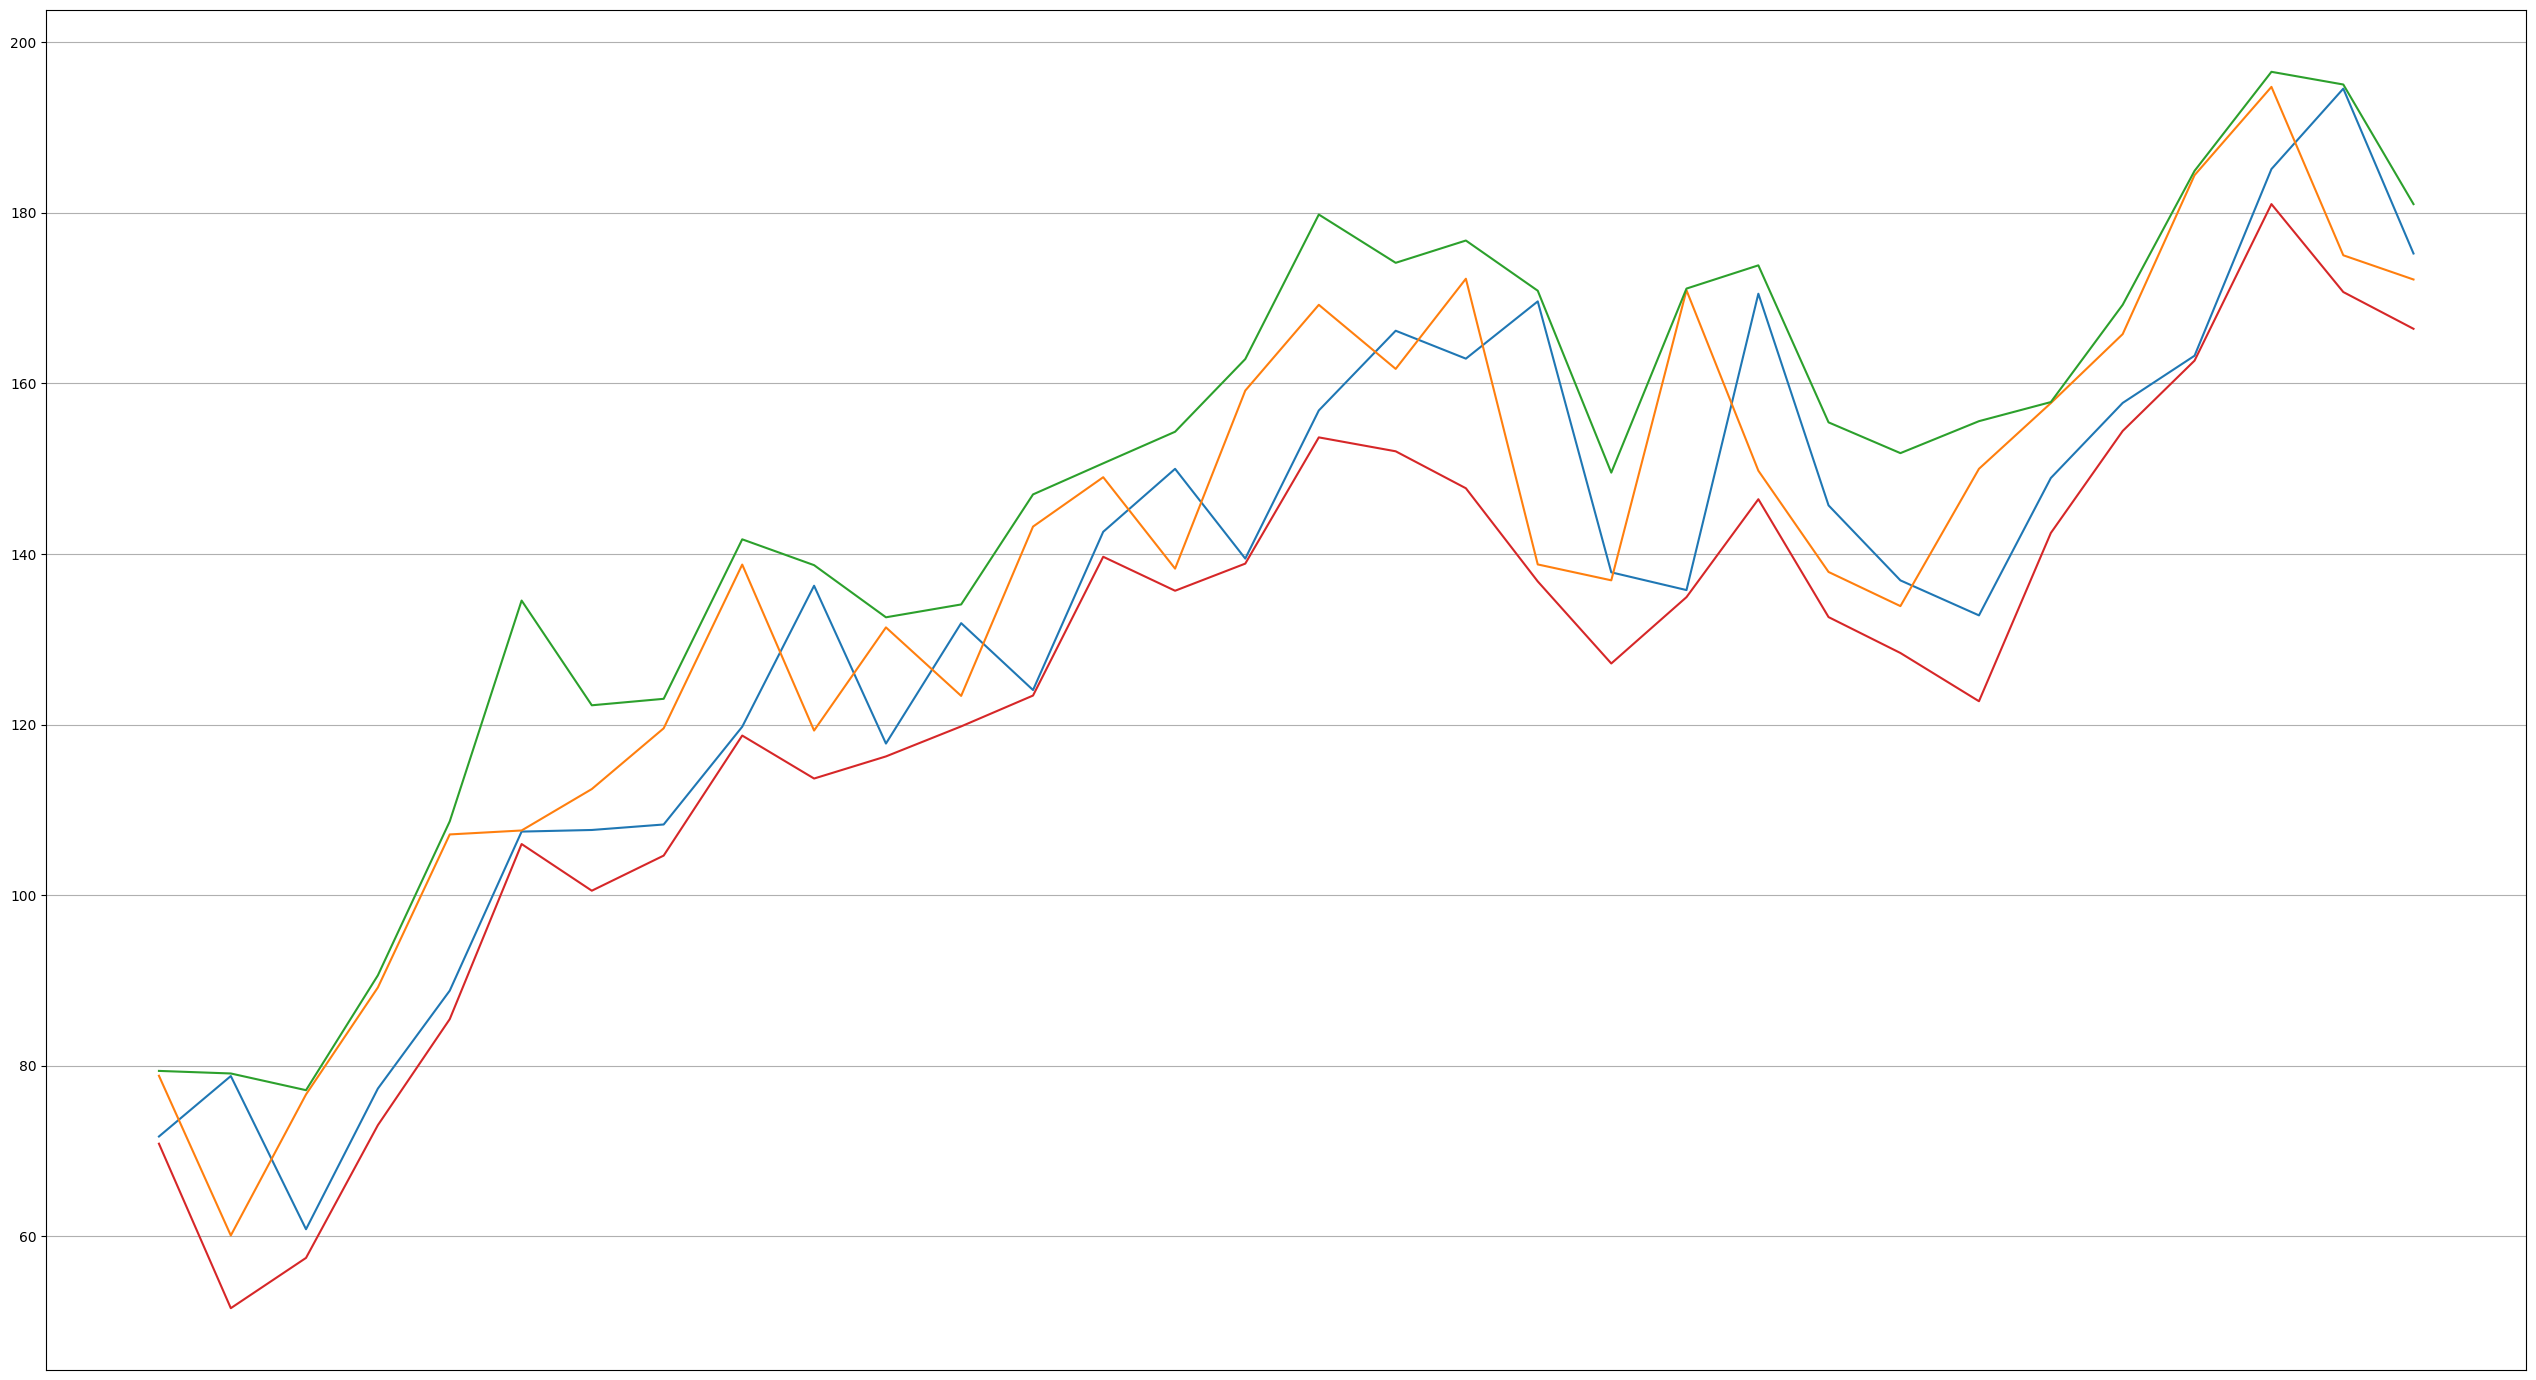

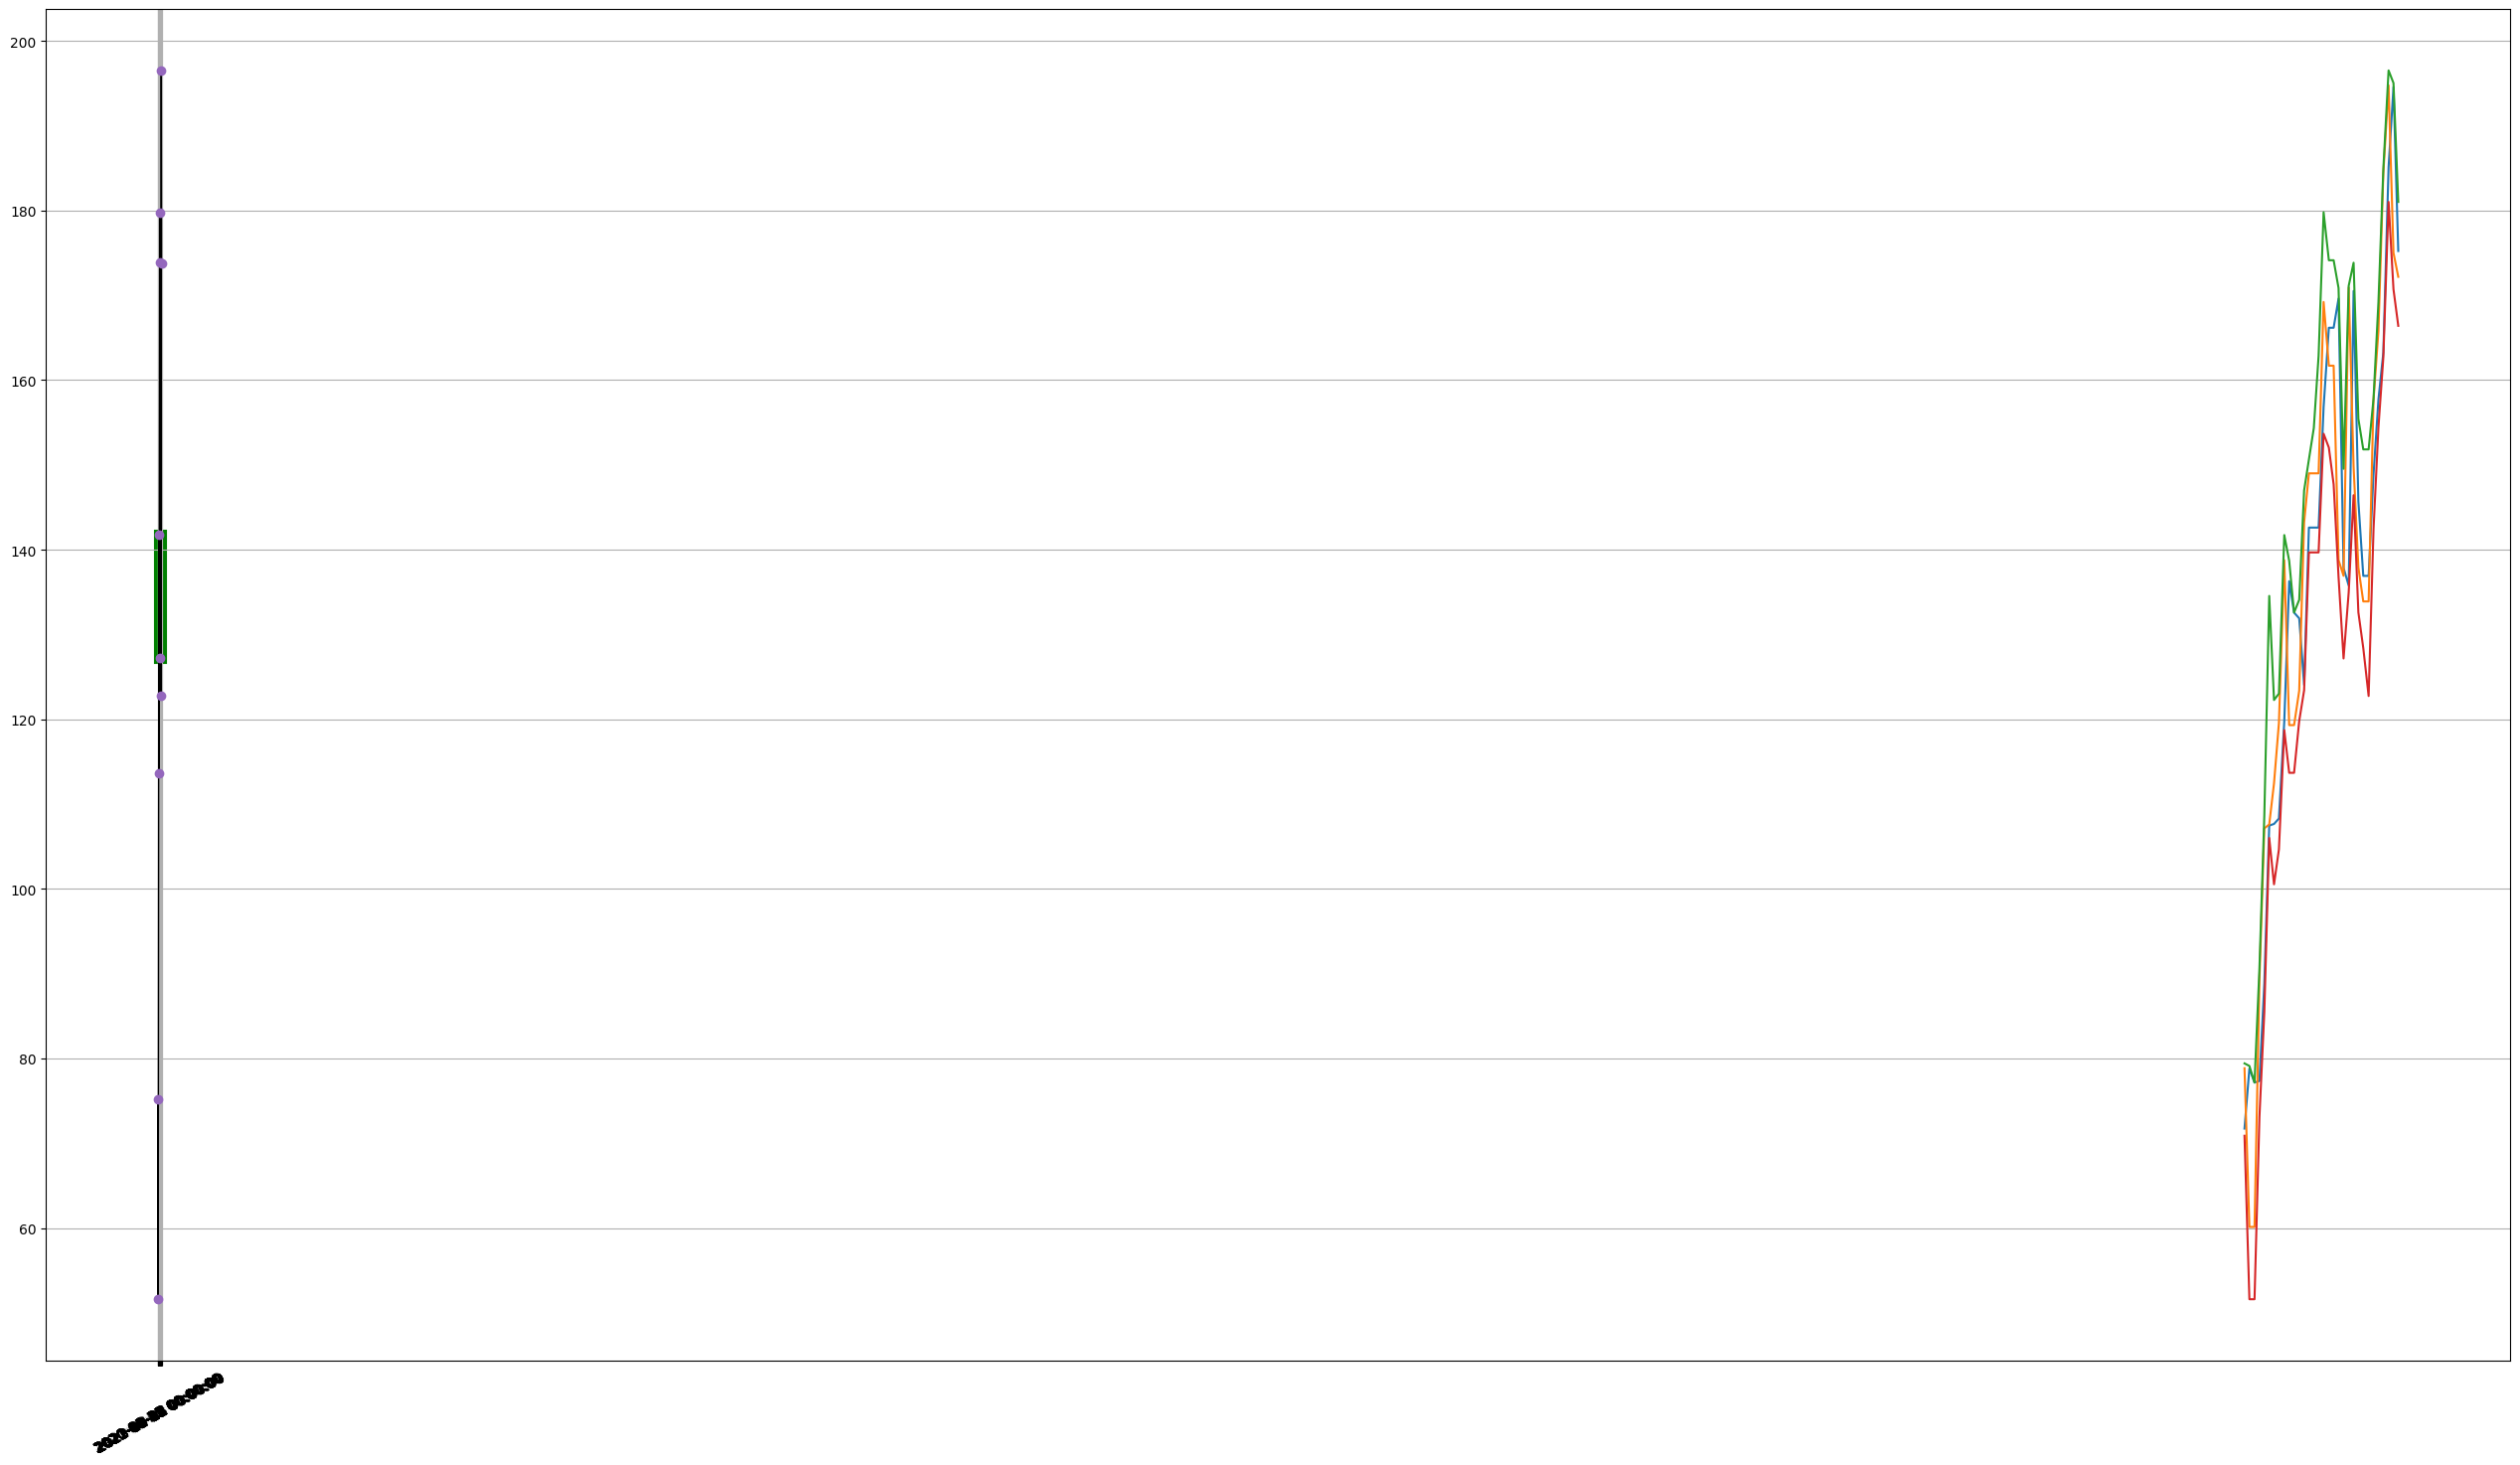

In [10]:
# 第三方函数库
import numpy as np  # 导入numpy库，用于数值计算
import pandas as pd  # 导入pandas库，用于数据处理
import datetime  # 导入datetime库，用于日期时间处理
import matplotlib.pyplot as plt  # 导入matplotlib.pyplot库，用于绘图
import matplotlib.patches as patches  # 导入matplotlib.patches库，用于绘制形状
import pandas_ta as ta  # 导入pandas_ta库，用于技术分析指标计算

def get_k_series(data, n=30):
    """
    获取k线序列，默认为30分钟级别
    :param data: pandas DataFrame，包含'Open', 'Close', 'High', 'Low'列
    :param n: int, 级别，单位是分钟
    :return: pandas DataFrame，k线序列
    """
    n_min_data = pd.DataFrame()  # 初始化n分钟级别k线数据帧
    for i in range(n, len(data) + 1, n):  # 遍历原始数据，以n分钟为间隔
        interval = data[i-n:i]  # 获取当前n分钟区间的数据
        interval_open = interval.iloc[0]['Open']  # 获取区间第一个开盘价
        interval_high = interval['High'].max()  # 获取区间最高价
        interval_low = interval['Low'].min()  # 获取区间最低价
        interval_k = interval.iloc[-1:].copy()  # 获取区间最后一个收盘价的DataFrame副本
        interval_k.loc[interval_k.index, 'Open'] = interval_open  # 设置区间开盘价
        interval_k.loc[interval_k.index, 'High'] = interval_high  # 设置区间最高价
        interval_k.loc[interval_k.index, 'Low'] = interval_low  # 设置区间最低价
        n_min_data = pd.concat([n_min_data, interval_k], axis=0)  # 连接当前区间k线数据
    return n_min_data  # 返回n分钟级别k线数据帧

def get_binary_positions(k_data):
    """
    计算k线序列的二分位值
    :param k_data: pandas DataFrame，k线序列
    :return: list, k线序列对应的二分位值
    """
    return [(row['High'] + row['Low']) / 2.0 for _, row in k_data.iterrows()]  # 计算每根k线高低点的二分位值

def adjust_by_cintainment(k_data):
    """
    判断k线的包含关系，便于寻找顶分型和底分型
    :param k_data: pandas DataFrame，k线序列
    :return: pandas DataFrame，处理后的k线序列
    """
    trend = [0]  # 初始化趋势列表
    adjusted_k_data = pd.DataFrame()  # 初始化调整后的k线数据帧
    temp_data = k_data.iloc[:1].copy()  # 初始化临时数据帧，包含第一根k线

    for i in range(len(k_data)):  # 遍历k线数据
        is_equal = temp_data['High'].iloc[-1] == k_data['High'].iloc[i] and temp_data['Low'].iloc[-1] == k_data['Low'].iloc[i]  # 判断是否包含关系

        if temp_data['High'].iloc[-1] >= k_data['High'].iloc[i] and temp_data['Low'].iloc[-1] <= k_data['Low'].iloc[i] and not is_equal:  # 如果当前k线被包含
            if trend[-1] == -1:  # 如果趋势向下
                temp_data.loc[temp_data.index[-1], 'High'] = k_data['High'].iloc[i]  # 更新临时数据最高价
            else:  # 如果趋势向上或无趋势
                temp_data.loc[temp_data.index[-1], 'Low'] = k_data['Low'].iloc[i]  # 更新临时数据最低价
        elif temp_data['High'].iloc[-1] <= k_data['High'].iloc[i] and temp_data['Low'].iloc[-1] >= k_data['Low'].iloc[i] and not is_equal:  # 如果当前k线包含临时数据
            if trend[-1] == -1:  # 如果趋势向下
                temp_data.loc[temp_data.index[-1], 'Low'] = k_data['Low'].iloc[i]  # 更新临时数据最低价
            else:  # 如果趋势向上或无趋势
                temp_data.loc[temp_data.index[-1], 'High'] = k_data['High'].iloc[i]  # 更新临时数据最高价
        elif is_equal:  # 如果相等
            trend.append(0)  # 添加无趋势
        elif temp_data['High'].iloc[-1] > k_data['High'].iloc[i] and temp_data['Low'].iloc[-1] > k_data['Low'].iloc[i]:  # 如果当前k线低于临时数据
            trend.append(-1)  # 添加向下趋势
            temp_data = k_data.iloc[i:i+1].copy()  # 更新临时数据为当前k线
        elif temp_data['High'].iloc[-1] < k_data['High'].iloc[i] and temp_data['Low'].iloc[-1] < k_data['Low'].iloc[i]:  # 如果当前k线高于临时数据
            trend.append(1)  # 添加向上趋势
            temp_data = k_data.iloc[i:i+1].copy()  # 更新临时数据为当前k线

        if temp_data['Open'].iloc[-1] > temp_data['Close'].iloc[-1]:  # 如果临时数据为阴线
            if temp_data['Open'].iloc[-1] > temp_data['High'].iloc[-1]:  # 如果开盘价高于最高价
                temp_data.loc[temp_data.index[-1], 'Open'] = temp_data['High'].iloc[-1]  # 更新开盘价为最高价
            if temp_data['Close'].iloc[-1] < temp_data['Low'].iloc[-1]:  # 如果收盘价低于最低价
                temp_data.loc[temp_data.index[-1], 'Close'] = temp_data['Low'].iloc[-1]  # 更新收盘价为最低价
        else:  # 如果临时数据为阳线
            if temp_data['Open'].iloc[-1] < temp_data['Low'].iloc[-1]:  # 如果开盘价低于最低价
                temp_data.loc[temp_data.index[-1], 'Open'] = temp_data['Low'].iloc[-1]  # 更新开盘价为最低价
            if temp_data['Close'].iloc[-1] > temp_data['High'].iloc[-1]:  # 如果收盘价高于最高价
                temp_data.loc[temp_data.index[-1], 'Close'] = temp_data['High'].iloc[-1]  # 更新收盘价为最高价

        adjusted_data = k_data.iloc[i:i+1].copy()  # 获取当前k线数据的副本
        adjusted_data.loc[adjusted_data.index[-1], 'Open'] = temp_data['Open'].iloc[-1]  # 更新调整后数据的开盘价
        adjusted_data.loc[adjusted_data.index[-1], 'Close'] = temp_data['Close'].iloc[-1]  # 更新调整后数据的收盘价
        adjusted_data.loc[adjusted_data.index[-1], 'High'] = temp_data['High'].iloc[-1]  # 更新调整后数据的最高价
        adjusted_data.loc[adjusted_data.index[-1], 'Low'] = temp_data['Low'].iloc[-1]  # 更新调整后数据的最低价
        adjusted_k_data = pd.concat([adjusted_k_data, adjusted_data], axis=0)  # 连接调整后的数据

    return adjusted_k_data  # 返回调整后的k线数据帧

def get_fx(adjusted_k_data):
    """
    寻找顶分型和底分型
    :param adjusted_k_data: pandas DataFrame，调整后的k线序列
    :return: 顶分型和底分型的位置
    """
    temp_num = 0  # 初始化临时分型点索引
    temp_high = 0  # 初始化临时最高价
    temp_low = 0  # 初始化临时最低价
    temp_type = 0  # 初始化临时分型类型
    fx_type = []  # 初始化分型类型列表
    fx_time = []  # 初始化分型时间列表
    fx_plot = []  # 初始化分型价格列表
    fx_data = pd.DataFrame()  # 初始化分型数据帧
    fx_offset = []  # 初始化分型偏移列表

    fx_type.append(0)  # 添加第一个分型类型
    fx_offset.append(0)  # 添加第一个分型偏移
    fx_time.append(adjusted_k_data.index[0].strftime("%Y-%m-%d %H:%M:%S"))  # 添加第一个分型时间
    fx_data = pd.concat([fx_data, adjusted_k_data.iloc[:1]], axis=0)  # 添加第一个分型数据
    fx_plot.append((adjusted_k_data['Low'].iloc[0] + adjusted_k_data['High'].iloc[0]) / 2)  # 添加第一个分型价格

    i = 1  # 初始化遍历索引
    while i < len(adjusted_k_data) - 1:  # 遍历调整后的k线数据
        top = adjusted_k_data['High'].iloc[i-1] <= adjusted_k_data['High'].iloc[i] and adjusted_k_data['High'].iloc[i] > adjusted_k_data['High'].iloc[i+1]  # 判断是否顶分型
        bottom = adjusted_k_data['Low'].iloc[i-1] >= adjusted_k_data['Low'].iloc[i] and adjusted_k_data['Low'].iloc[i] < adjusted_k_data['Low'].iloc[i+1]  # 判断是否底分型

        if top:  # 如果是顶分型
            if temp_type == 1:  # 如果前一个分型是顶分型
                if adjusted_k_data['High'].iloc[i] <= temp_high:  # 如果当前顶分型低于前一个顶分型
                    i += 1  # 跳过当前k线
                else:  # 如果当前顶分型高于前一个顶分型
                    temp_high = adjusted_k_data['High'].iloc[i]  # 更新临时最高价
                    temp_low = adjusted_k_data['Low'].iloc[i]  # 更新临时最低价
                    temp_num = i  # 更新临时分型点索引
                    temp_type = 1  # 更新临时分型类型
                    i += 2  # 跳过当前分型点和下一个k线
            elif temp_type == -1:  # 如果前一个分型是底分型
                if temp_low >= adjusted_k_data['High'].iloc[i]:  # 如果前一个底分型高于当前顶分型
                    i += 1  # 跳过当前k线
                else:  # 如果前一个底分型低于当前顶分型
                    fx_type.append(-1)  # 添加底分型
                    fx_time.append(adjusted_k_data.index[temp_num].strftime("%Y-%m-%d %H:%M:%S"))  # 添加底分型时间
                    fx_data = pd.concat([fx_data, adjusted_k_data.iloc[temp_num:temp_num+1]], axis=0)  # 添加底分型数据
                    fx_plot.append(temp_low)  # 添加底分型价格
                    fx_offset.append(temp_num)  # 添加底分型偏移
                    temp_high = adjusted_k_data['High'].iloc[i]  # 更新临时最高价
                    temp_low = adjusted_k_data['Low'].iloc[i]  # 更新临时最低价
                    temp_num = i  # 更新临时分型点索引
                    temp_type = 1  # 更新临时分型类型
                    i += 2  # 跳过当前分型点和下一个k线
            else:  # 如果前一个分型是无分型
                temp_high = adjusted_k_data['High'].iloc[i]  # 更新临时最高价
                temp_low = adjusted_k_data['Low'].iloc[i]  # 更新临时最低价
                temp_num = i  # 更新临时分型点索引
                temp_type = 1  # 更新临时分型类型
                i += 2  # 跳过当前分型点和下一个k线
        elif bottom:  # 如果是底分型
            if temp_type == -1:  # 如果前一个分型是底分型
                if adjusted_k_data['Low'].iloc[i] >= temp_low:  # 如果当前底分型高于前一个底分型
                    i += 1  # 跳过当前k线
                else:  # 如果当前底分型低于前一个底分型
                    temp_low = adjusted_k_data['Low'].iloc[i]  # 更新临时最低价
                    temp_high = adjusted_k_data['High'].iloc[i]  # 更新临时最高价
                    temp_num = i  # 更新临时分型点索引
                    temp_type = -1  # 更新临时分型类型
                    i += 3  # 跳过当前分型点和下一个k线
            elif temp_type == 1:  # 如果前一个分型是顶分型
                if temp_high <= adjusted_k_data['Low'].iloc[i]:  # 如果前一个顶分型低于当前底分型
                    i += 1  # 跳过当前k线
                else:  # 如果前一个顶分型高于当前底分型
                    fx_type.append(1)  # 添加顶分型
                    fx_time.append(adjusted_k_data.index[temp_num].strftime("%Y-%m-%d %H:%M:%S"))  # 添加顶分型时间
                    fx_data = pd.concat([fx_data, adjusted_k_data.iloc[temp_num:temp_num+1]], axis=0)  # 添加顶分型数据
                    fx_plot.append(temp_high)  # 添加顶分型价格
                    fx_offset.append(temp_num)  # 添加顶分型偏移
                    temp_low = adjusted_k_data['Low'].iloc[i]  # 更新临时最低价
                    temp_high = adjusted_k_data['High'].iloc[i]  # 更新临时最高价
                    temp_num = i  # 更新临时分型点索引
                    temp_type = -1  # 更新临时分型类型
                    i += 2  # 跳过当前分型点和下一个k线
            else:  # 如果前一个分型是无分型
                temp_low = adjusted_k_data['Low'].iloc[i]  # 更新临时最低价
                temp_high = adjusted_k_data['High'].iloc[i]  # 更新临时最高价
                temp_num = i  # 更新临时分型点索引
                temp_type = -1  # 更新临时分型类型
                i += 2  # 跳过当前分型点和下一个k线
        else:  # 如果不是分型
            i += 1  # 跳过当前k线

    if temp_type == -1:  # 如果最后一个分型是底分型
        fx_type.append(-1)  # 添加底分型
        fx_time.append(adjusted_k_data.index[temp_num].strftime("%Y-%m-%d %H:%M:%S"))  # 添加底分型时间
        fx_data = pd.concat([fx_data, adjusted_k_data.iloc[temp_num:temp_num+1]], axis=0)  # 添加底分型数据
        fx_plot.append(temp_low)  # 添加底分型价格
        fx_offset.append(temp_num)  # 添加底分型偏移
    elif temp_type == 1:  # 如果最后一个分型是顶分型
        fx_type.append(1)  # 添加顶分型
        fx_time.append(adjusted_k_data.index[temp_num].strftime("%Y-%m-%d %H:%M:%S"))  # 添加顶分型时间
        fx_data = pd.concat([fx_data, adjusted_k_data.iloc[temp_num:temp_num+1]], axis=0)  # 添加顶分型数据
        fx_plot.append(temp_high)  # 添加顶分型价格
        fx_offset.append(temp_num)  # 添加顶分型偏移

    fx_type.append(0)  # 添加最后一个分型类型
    fx_offset.append(len(adjusted_k_data) - 1)  # 添加最后一个分型偏移
    fx_time.append(adjusted_k_data.index[-1].strftime("%Y-%m-%d %H:%M:%S"))  # 添加最后一个分型时间
    fx_data = pd.concat([fx_data.iloc[-1:]], axis=0)  # 添加最后一个分型数据
    fx_plot.append((adjusted_k_data['Low'].iloc[-1] + adjusted_k_data['High'].iloc[-1]) / 2)  # 添加最后一个分型价格

    return fx_type, fx_time, fx_data, fx_plot, fx_offset  # 返回分型类型、时间、数据、价格、偏移列表

def get_pivot(fx_plot, fx_offset, fx_observe):
    """
    计算最近的中枢
    :param fx_plot: list, 笔的节点股价
    :param fx_offset: list, 笔的节点时间点（偏移）
    :param fx_observe: int, 所观测的分型点
    :return: pivot_x_interval, pivot_price_interval
    """
    if fx_observe < 1:  # 如果观测点小于1
        return [0, 0], [0, 0]  # 返回无效中枢

    right_bound = (fx_offset[fx_observe] + fx_offset[fx_observe - 1]) / 2  # 计算右边界
    left_bound = 0  # 初始化左边界
    min_high = 0  # 初始化最小高点
    max_low = 0  # 初始化最大低点

    if fx_plot[fx_observe] >= fx_plot[fx_observe - 1]:  # 如果观测点价格高于前一个点
        min_high = fx_plot[fx_observe]  # 更新最小高点
        max_low = fx_plot[fx_observe - 1]  # 更新最大低点
    else:  # 如果观测点价格低于前一个点
        max_low = fx_plot[fx_observe]  # 更新最大低点
        min_high = fx_plot[fx_observe - 1]  # 更新最小高点

    i = fx_observe - 1  # 初始化遍历索引
    cover = 0  # 初始化覆盖次数
    while i >= 1:  # 遍历分型点
        if fx_plot[i] >= fx_plot[i - 1]:  # 如果当前点价格高于前一个点
            if fx_plot[i] < max_low or fx_plot[i - 1] > min_high:  # 如果当前点价格超出中枢范围
                left_bound = (fx_offset[i] + fx_offset[i + 1]) / 2  # 计算左边界
                break  # 跳出循环
            else:  # 如果当前点价格在中枢范围内
                cover += 1  # 覆盖次数加1
                min_high = min(fx_plot[i], min_high)  # 更新最小高点
                max_low = max(fx_plot[i - 1], max_low)  # 更新最大低点
        elif fx_plot[i] < fx_plot[i - 1]:  # 如果当前点价格低于前一个点
            if fx_plot[i] > min_high or fx_plot[i - 1] < max_low:  # 如果当前点价格超出中枢范围
                left_bound = (fx_offset[i] + fx_offset[i + 1]) / 2  # 计算左边界
                break  # 跳出循环
            else:  # 如果当前点价格在中枢范围内
                cover += 3  # 覆盖次数加3
                min_high = min(fx_plot[i - 1], min_high)  # 更新最小高点
                max_low = max(fx_plot[i], max_low)  # 更新最大低点
        i -= 1  # 索引减1

    if cover < 3:  # 如果覆盖次数小于3
        return [0, 0], [0, 0]  # 返回无效中枢

    return [left_bound, right_bound], [max_low, min_high]  # 返回中枢的时间和价格区间

def plot_k_series(k_data):
    """
    画k线
    :param k_data: pandas DataFrame，k线数据
    :return: matplotlib Axes 对象
    """
    num_of_ticks = len(k_data)  # 获取k线数量
    fig, ax = plt.subplots(figsize=(num_of_ticks, 20))  # 创建画布和子图
    fig.subplots_adjust(bottom=0.2)  # 调整子图底部边距
    dates = k_data.index  # 获取日期索引
    ax.set_xticks(np.linspace(1, num_of_ticks, num_of_ticks))  # 设置x轴刻度
    ax.set_xticklabels(list(dates))  # 设置x轴刻度标签
    ax.plot(k_data['Open'], label="Open")  # 绘制开盘价线
    ax.plot(k_data['Close'], label="Close")  # 绘制收盘价线
    ax.plot(k_data['High'], label="High")  # 绘制最高价线
    ax.plot(k_data['Low'], label="Low")  # 绘制最低价线
    plt.grid(True)  # 显示网格线
    plt.setp(plt.gca().get_xticklabels(), rotation=30)  # 设置x轴刻度标签旋转角度
    return ax  # 返回子图对象

def plot_lines(ax, fx_plot, fx_offset):
    """
    绘制笔和线段
    :param ax: matplotlib Axes 对象
    :param fx_plot: list, 笔的节点股价
    :param fx_offset: list, 笔的节点时间点（偏移）
    """
    plt.plot(fx_offset, fx_plot, 'k', lw=1)  # 绘制线段
    plt.plot(fx_offset, fx_plot, 'o')  # 绘制节点

def plot_pivot(ax, pivot_date_interval, pivot_price_interval):
    """
    绘制中枢
    :param ax: matplotlib Axes 对象
    :param pivot_date_interval: list, 中枢的日期区间
    :param pivot_price_interval: list, 中枢的价格区间
    """
    start_point = (pivot_date_interval[0], pivot_price_interval[0])  # 计算中枢左下角坐标
    width = pivot_date_interval[1] - pivot_date_interval[0]  # 计算中枢宽度
    height = pivot_price_interval[1] - pivot_price_interval[0]  # 计算中枢高度
    ax.add_patch(  # 添加矩形
        patches.Rectangle(
            start_point,
            width,
            height,
            linewidth=8,
            edgecolor='g',
            facecolor='none'
        )
    )

def check_deviating(scode, data, fastperiod=11, slowperiod=26, signalperiod=9):
    """
    日线级别，计算昨天收盘是否发生顶或底背离，利用快慢线金、死叉判断
    :param scode: str, 证券代码
    :param data: pandas DataFrame，包含'close'列的日线数据
    :param fastperiod: int, MACD参数
    :param slowperiod: int, MACD参数
    :param signalperiod: int, MACD参数
    :return: int, dev_type, 0：没有背离，1：发生顶背离，-1：发生底背离
    """
    close = data['Close']  # 获取收盘价序列
    macd = ta.macd(close, fast=fastperiod, slow=slowperiod, signal=signalperiod)  # 计算MACD指标
    dif = macd['MACD_12_26_9']  # 获取DIF序列
    dea = macd['MACDs_12_26_9']  # 获取DEA序列
    macd = macd['MACDh_12_26_9']  # 获取MACD柱状图序列
    dev_type = 0  # 初始化背离类型

    if macd.iloc[-1] > 0 > macd.iloc[-2]:  # 如果MACD柱状图由负转正
        idx_gold = np.where((macd[:-1] < 0) & (macd[1:] > 0))[0] + 1  # 获取金叉索引
        if len(idx_gold) > 1:  # 如果金叉数量大于1
            if close.iloc[idx_gold[-1]] < close.iloc[idx_gold[-2]] and dif.iloc[idx_gold[-1]] > dif.iloc[idx_gold[-2]]:  # 如果股价下跌但DIF上升
                dev_type= -1  # 设置背离类型为底背离

    elif macd.iloc[-1] < 0 < macd.iloc[-2]:  # 如果MACD柱状图由正转负
        idx_dead = np.where((macd[:-1] > 0) & (macd[1:] < 0))[0] + 1  # 获取死叉索引
        if len(idx_dead) > 1:  # 如果死叉数量大于1
            if close.iloc[idx_dead[-1]] > close.iloc[idx_dead[-2]] and dif.iloc[idx_dead[-1]] < dif.iloc[idx_dead[-2]]:  # 如果股价上涨但DIF下跌
                dev_type = 1  # 设置背离类型为顶背离

    return dev_type  # 返回背离类型

if __name__ == "__main__":
    data = pd.read_csv('stock_1d.csv', index_col='Date', parse_dates=True)  # 读取股票数据
    start_date = datetime.datetime(2020, 1, 2)  # 设置开始日期
    end_date = datetime.datetime(2021, 5, 26)  # 设置结束日期
    k_series = get_k_series(data, 30)  # 获取30分钟级别k线序列
    plot_k_series(k_series)  # 绘制原始k线图

    adjusted_k_data = adjust_by_cintainment(k_series)  # 调整k线序列
    ax = plot_k_series(adjusted_k_data)  # 绘制调整后的k线图

    fx_type, fx_time, fx_data, fx_plot, fx_offset = get_fx(adjusted_k_data)  # 获取分型数据
    print(fx_type, fx_time)  # 打印分型类型和时间
    plot_lines(ax, fx_plot, fx_offset)  # 绘制笔和线段

    pivot_x_interval, pivot_price_interval = get_pivot(fx_plot, fx_offset, len(fx_offset) - 2)  # 获取最近中枢
    plot_pivot(ax, pivot_x_interval, pivot_price_interval)  # 绘制中枢

    plt.show()  # 显示图形


数据加载成功，样本数: 961

数据前5行:
                Close       High        Low       Open     Volume
Date                                                             
2020-01-02  72.716080  72.776606  71.466820  71.721026  135480400
2020-01-03  72.009132  72.771760  71.783977  71.941343  146322800
2020-01-06  72.582893  72.621631  70.876060  71.127851  118387200
2020-01-07  72.241531  72.849208  72.021215  72.592578  108872000
2020-01-08  73.403641  73.706271  71.943751  71.943751  132079200

处理包含关系...
处理完成，调整后数据量: 793

识别分型...
识别出的分型数量: 348

开始绘制图表...


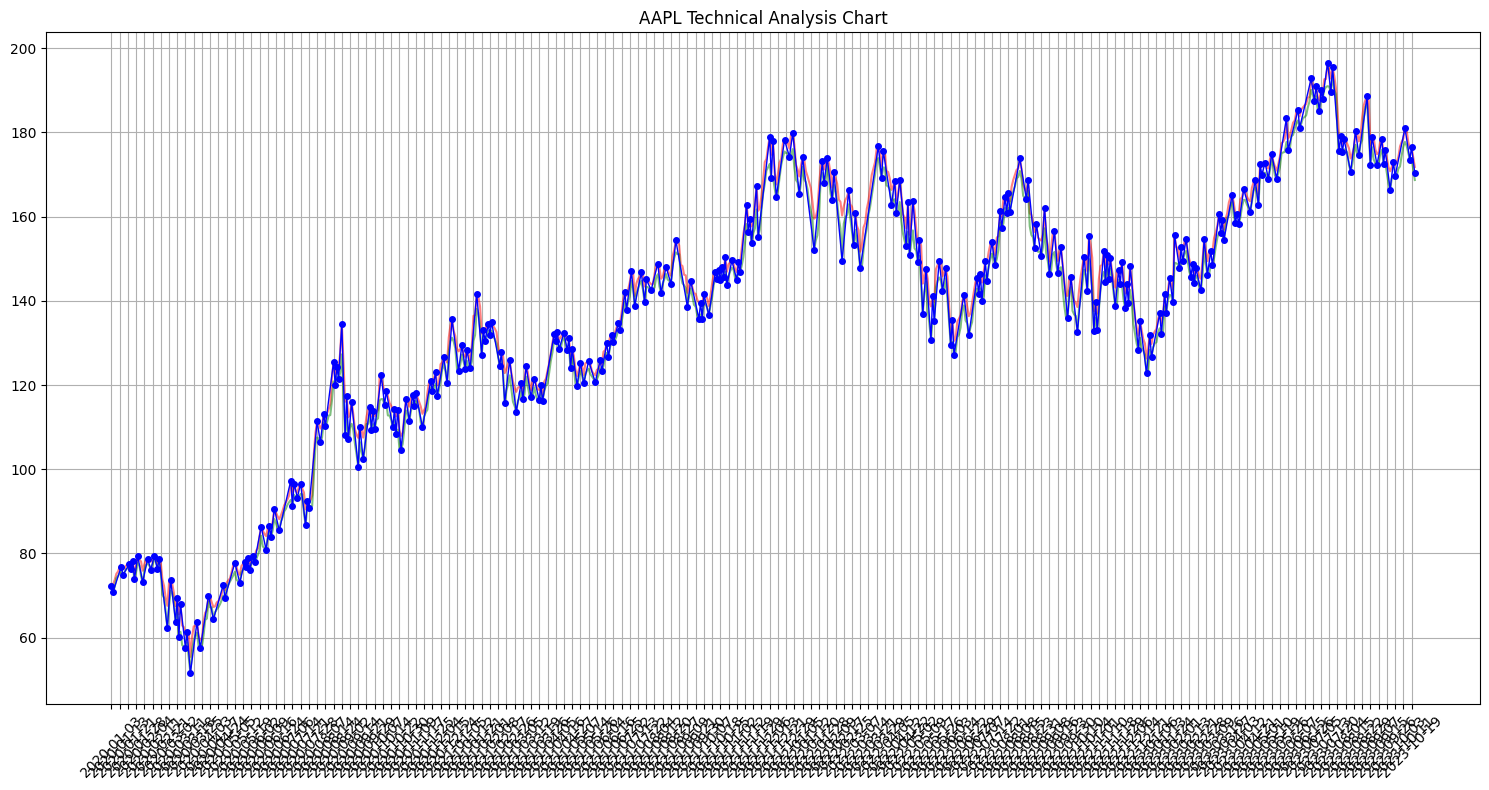

In [11]:
import numpy as np  # 导入numpy库，用于数值计算
import pandas as pd  # 导入pandas库，用于数据处理
import datetime  # 导入datetime库，用于日期时间处理
import matplotlib.pyplot as plt  # 导入matplotlib.pyplot库，用于绘图
import matplotlib.patches as patches  # 导入matplotlib.patches库，用于绘制形状
import pandas_ta as ta  # 导入pandas_ta库，用于技术分析指标计算
from dataclasses import dataclass  # 导入dataclasses库，用于创建数据类
from typing import List, Tuple, Optional  # 导入typing库，用于类型注解
from datetime import datetime  # 导入datetime类，用于日期时间操作

@dataclass  # 使用dataclass装饰器创建数据类
class FractalPoint:
    """分型点数据类"""
    type: int  # 1: 顶分型, -1: 底分型, 0: 起始/结束点
    time: str  # 分型点时间
    price: float  # 分型点价格
    offset: int  # 分型点偏移量

@dataclass  # 使用dataclass装饰器创建数据类
class PivotRange:
    """中枢范围数据类"""
    x_range: Tuple[float, float]  # 时间范围
    price_range: Tuple[float, float]  # 价格范围

class TechnicalAnalysis:
    """技术分析类"""

    def __init__(self, data: pd.DataFrame):
        """
        初始化技术分析类

        Args:
            data: DataFrame with columns ['Open', 'High', 'Low', 'Close']
        """
        self.validate_data(data)  # 验证输入数据
        self.data = data  # 存储输入数据

    @staticmethod
    def validate_data(data: pd.DataFrame) -> None:
        """验证输入数据的完整性"""
        required_columns = ['Open', 'High', 'Low', 'Close']  # 定义必需的列名
        if not all(col in data.columns for col in required_columns):  # 检查所有必需的列是否存在
            raise ValueError(f"Data must contain columns: {required_columns}")  # 如果缺少列，则抛出异常
        if len(data) < 3:  # 检查数据长度是否足够
            raise ValueError("Need at least 3 k-lines for analysis")  # 如果数据长度不足，则抛出异常

    def get_k_series(self, n: int = 30) -> pd.DataFrame:
        """
        获取K线序列

        Args:
            n: 周期（分钟）

        Returns:
            转换后的K线数据
        """
        if len(self.data) < n:  # 如果数据长度小于周期，则直接返回原始数据
            return self.data.copy()  # 返回原始数据的副本

        result = []  # 初始化结果列表
        for i in range(0, len(self.data), n):  # 遍历原始数据，以周期为步长
            chunk = self.data.iloc[i:i+n]  # 获取当前周期的数据块
            if len(chunk) > 0:  # 如果数据块不为空
                result.append({  # 将数据块的第一个开盘价、最高价、最低价、最后一个收盘价和最后一个时间添加到结果列表中
                    'Open': chunk['Open'].iloc[0],
                    'High': chunk['High'].max(),
                    'Low': chunk['Low'].min(),
                    'Close': chunk['Close'].iloc[-1],
                    'Date': chunk.index[-1]
                })

        df = pd.DataFrame(result)  # 将结果列表转换为DataFrame
        df.set_index('Date', inplace=True)  # 将日期列设置为索引
        return df  # 返回转换后的K线数据

    def adjust_by_containment(self, k_data: pd.DataFrame = None) -> pd.DataFrame:
        """
        处理K线包含关系

        Args:
            k_data: 输入的K线数据，如果为None则使用self.data

        Returns:
            处理后的K线数据
        """
        if k_data is None:  # 如果没有提供K线数据，则使用self.data
            k_data = self.data.copy()  # 使用self.data的副本

        if len(k_data) < 2:  # 如果K线数据长度小于2，则直接返回原始数据
            return k_data  # 返回原始数据

        result = []  # 初始化结果列表
        curr_k = k_data.iloc[0].copy()  # 初始化当前K线为第一根K线
        trend = 0  # 0: 初始, 1: 向上, -1: 向下  # 初始化趋势为初始状态

        for i in range(1, len(k_data)):  # 遍历K线数据
            next_k = k_data.iloc[i]  # 获取下一根K线

            # 判断是否存在包含关系
            contained = (
                (curr_k['High'] >= next_k['High'] and curr_k['Low'] <= next_k['Low']) or
                (curr_k['High'] <= next_k['High'] and curr_k['Low'] >= next_k['Low'])
            )

            if contained:  # 如果存在包含关系
                # 根据趋势合并K线
                if trend >= 0:  # 如果趋势向上或初始状态
                    curr_k['High'] = max(curr_k['High'], next_k['High'])  # 更新当前K线最高价
                    curr_k['Low'] = max(curr_k['Low'], next_k['Low'])  # 更新当前K线最低价
                else:  # 如果趋势向下
                    curr_k['High'] = min(curr_k['High'], next_k['High'])  # 更新当前K线最高价
                    curr_k['Low'] = min(curr_k['Low'], next_k['Low'])  # 更新当前K线最低价
            else:  # 如果不存在包含关系
                # 添加当前K线到结果中
                result.append({  # 将当前K线添加到结果列表中
                    'Open': curr_k['Open'],
                    'High': curr_k['High'],
                    'Low': curr_k['Low'],
                    'Close': curr_k['Close'],
                    'Date': k_data.index[i-1]
                })

                # 更新趋势
                if next_k['High'] > curr_k['High'] and next_k['Low'] > curr_k['Low']:  # 如果下一根K线高于当前K线
                    trend = 1  # 设置趋势为向上
                elif next_k['High'] < curr_k['High'] and next_k['Low'] < curr_k['Low']:  # 如果下一根K线低于当前K线
                    trend = -1  # 设置趋势为向下

                curr_k = next_k.copy()  # 更新当前K线为下一根K线

        # 添加最后一个K线
        result.append({  # 将最后一根K线添加到结果列表中
            'Open': curr_k['Open'],
            'High': curr_k['High'],
            'Low': curr_k['Low'],
            'Close': curr_k['Close'],
            'Date': k_data.index[-1]
        })

        df = pd.DataFrame(result)  # 将结果列表转换为DataFrame
        df.set_index('Date', inplace=True)  # 将日期列设置为索引
        return df  # 返回处理后的K线数据

    def get_fx(self, k_data: pd.DataFrame = None) -> Tuple[List[int], List[str], pd.DataFrame, List[float], List[int]]:
        """
        识别分型

        Args:
            k_data: 输入的K线数据，如果为None则使用self.data

        Returns:
            分型类型列表，时间列表，分型数据，分型价格列表，分型位置列表
        """
        if k_data is None:  # 如果没有提供K线数据，则使用调整后的K线数据
            k_data = self.adjust_by_containment()  # 使用调整后的K线数据

        fractals = []  # 初始化分型列表

        # 添加起始点
        fractals.append(FractalPoint(  # 添加起始分型点
            type=0,
            time=k_data.index[0].strftime("%Y-%m-%d %H:%M:%S"),
            price=(k_data['Low'].iloc[0] + k_data['High'].iloc[0]) / 2,
            offset=0
        ))

        # 识别分型
        for i in range(1, len(k_data)-1):  # 遍历K线数据
            # 获取连续三根K线
            k1 = k_data.iloc[i-1]
            k2 = k_data.iloc[i]
            k3 = k_data.iloc[i+1]

            # 顶分型
            if (k1['High'] <= k2['High'] and k2['High'] > k3['High']):  # 如果当前K线最高价高于前后K线最高价
                fractals.append(FractalPoint(  # 添加顶分型点
                    type=1,
                    time=k_data.index[i].strftime("%Y-%m-%d %H:%M:%S"),
                    price=k2['High'],
                    offset=i
                ))

            # 底分型
            elif (k1['Low'] >= k2['Low'] and k2['Low'] < k3['Low']):  # 如果当前K线最低价低于前后K线最低价
                fractals.append(FractalPoint(  # 添加底分型点
                    type=-1,
                    time=k_data.index[i].strftime("%Y-%m-%d %H:%M:%S"),
                    price=k2['Low'],
                    offset=i
                ))

        # 添加结束点
        fractals.append(FractalPoint(  # 添加结束分型点
            type=0,
            time=k_data.index[-1].strftime("%Y-%m-%d %H:%M:%S"),
            price=(k_data['Low'].iloc[-1] + k_data['High'].iloc[-1]) / 2,
            offset=len(k_data)-1
        ))

        # 构建返回数据
        fx_type = [f.type for f in fractals]  # 获取分型类型列表
        fx_time = [f.time for f in fractals]  # 获取分型时间列表
        fx_plot = [f.price for f in fractals]  # 获取分型价格列表
        fx_offset = [f.offset for f in fractals]  # 获取分型偏移列表

        fx_data = pd.DataFrame([  # 创建分型数据DataFrame
            k_data.iloc[f.offset] for f in fractals
        ], index=[k_data.index[f.offset] for f in fractals])

        return fx_type, fx_time, fx_data, fx_plot, fx_offset  # 返回分型类型、时间、数据、价格、偏移列表

class ChartPlotter:
    """图表绘制类"""

    def __init__(self, k_data: pd.DataFrame):
        self.k_data = k_data  # 存储K线数据

    def plot_k_series(self) -> plt.Axes:
        """绘制K线图"""
        fig, ax = plt.subplots(figsize=(15, 8))  # 创建画布和子图

        # 绘制K线
        ax.plot(range(len(self.k_data)), self.k_data['High'], 'r-', alpha=0.5)  # 绘制最高价线
        ax.plot(range(len(self.k_data)), self.k_data['Low'], 'g-', alpha=0.5)  # 绘制最低价线

        # 设置x轴标签
        plt.xticks(range(0, len(self.k_data), 5),  # 设置x轴刻度
                  [d.strftime('%Y-%m-%d') for d in self.k_data.index[::5]],  # 设置x轴刻度标签
                  rotation=45)  # 设置x轴刻度标签旋转角度

        plt.grid(True)  # 显示网格线
        return ax  # 返回子图对象

    @staticmethod
    def plot_lines(ax: plt.Axes, fx_plot: List[float], fx_offset: List[int]) -> None:
        """绘制分型连线"""
        ax.plot(fx_offset, fx_plot, 'b-', linewidth=1)  # 绘制分型连线
        ax.plot(fx_offset, fx_plot, 'bo', markersize=4)  # 绘制分型点

    @staticmethod
    def plot_pivot(ax: plt.Axes, pivot: PivotRange) -> None:
        """绘制中枢区间"""
        if pivot.x_range[0] == 0 and pivot.x_range[1] == 0:  # 如果中枢无效
            return  # 直接返回

        rect = patches.Rectangle(  # 创建矩形对象
            (pivot.x_range[0], pivot.price_range[0]),  # 设置矩形左下角坐标
            pivot.x_range[1] - pivot.x_range[0],  # 设置矩形宽度
            pivot.price_range[1] - pivot.price_range[0],  # 设置矩形高度
            linewidth=1,  # 设置线宽
            edgecolor='g',  # 设置边框颜色
            facecolor='g',  # 设置填充颜色
            alpha=0.2  # 设置透明度
        )
        ax.add_patch(rect)  # 添加矩形到子图

def calculate_pivot(fx_plot: List[float], fx_offset: List[int], fx_observe: int) -> PivotRange:
    """计算中枢"""
    if fx_observe < 1:  # 如果观测点无效
        return PivotRange((0, 0), (0, 0))  # 返回无效中枢

    right_bound = (fx_offset[fx_observe] + fx_offset[fx_observe - 1]) / 2  # 计算右边界
    left_bound = 0  # 初始化左边界
    min_high = max(fx_plot[fx_observe], fx_plot[fx_observe - 1])  # 初始化最小高点
    max_low = min(fx_plot[fx_observe], fx_plot[fx_observe - 1])  # 初始化最大低点

    count = 0  # 初始化覆盖次数
    i = fx_observe - 1  # 初始化遍历索引

    while i >= 1:  # 遍历分型点
        curr_high = max(fx_plot[i], fx_plot[i - 1])  # 获取当前高点
        curr_low = min(fx_plot[i], fx_plot[i - 1])  # 获取当前低点

        if curr_high < max_low or curr_low > min_high:  # 如果当前高点低于最大低点或当前低点高于最小高点
            left_bound = (fx_offset[i] + fx_offset[i + 1]) / 2  # 计算左边界
            break  # 跳出循环

        min_high = min(min_high, curr_high)  # 更新最小高点
        max_low = max(max_low, curr_low)  # 更新最大低点
        count += 1  # 覆盖次数加1
        i -= 1  # 索引减1

    if count < 3:  # 如果覆盖次数小于3
        return PivotRange((0, 0), (0, 0))  # 返回无效中枢

    return PivotRange((left_bound, right_bound), (max_low, min_high))  # 返回中枢范围

def main():
    # 创建示例数据
    dates = pd.date_range(start='2020-01-01', end='2023-12-31', freq='D')  # 创建日期范围
    np.random.seed(42)  # 设置随机数种子

    data = pd.DataFrame({  # 创建DataFrame
        'Open': np.random.normal(100, 10, len(dates)),  # 生成随机开盘价
        'High': np.random.normal(105, 10, len(dates)),  # 生成随机最高价
        'Low': np.random.normal(95, 10, len(dates)),  # 生成随机最低价
        'Close': np.random.normal(100, 10, len(dates))  # 生成随机收盘价
    }, index=dates)  # 设置索引为日期

    # 确保High和Low的正确性
    data['High'] = data[['Open', 'High', 'Close']].max(axis=1)  # 确保最高价不低于开盘价和收盘价
    data['Low'] = data[['Open', 'Low', 'Close']].min(axis=1)  # 确保最低价不高于开盘价和收盘价

    try:
        # 创建技术分析对象
        ta = TechnicalAnalysis(data)

        # 获取K线序列
        k_series = ta.get_k_series(30)

        # 处理包含关系
        adjusted_k_data = ta.adjust_by_containment(k_series)

        # 识别分型
        fx_type, fx_time, fx_data, fx_plot, fx_offset = ta.get_fx(adjusted_k_data)

        # 创建绘图对象
        plotter = ChartPlotter(adjusted_k_data)

        # 绘制图表
        ax = plotter.plot_k_series()
        plotter.plot_lines(ax, fx_plot, fx_offset)

        # 计算并绘制中枢
        pivot = calculate_pivot(fx_plot, fx_offset, len(fx_offset) - 2)
        plotter.plot_pivot(ax, pivot)

        plt.title('Technical Analysis Chart')
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"分析过程中出现错误: {str(e)}")
        import traceback
        traceback.print_exc()

def main():
    try:
        # 读取数据
        data = pd.read_csv('stock_1d.csv',
                          index_col='Date',
                          parse_dates=True)

        print("数据加载成功，样本数:", len(data))
        print("\n数据前5行:")
        print(data.head())

        # 创建技术分析对象
        ta = TechnicalAnalysis(data)

        # 获取K线序列 (使用原始日线数据，不需要转换周期)
        k_series = data.copy()  # 直接使用日线数据

        # 处理包含关系
        print("\n处理包含关系...")
        adjusted_k_data = ta.adjust_by_containment(k_series)
        print("处理完成，调整后数据量:", len(adjusted_k_data))

        # 识别分型
        print("\n识别分型...")
        fx_type, fx_time, fx_data, fx_plot, fx_offset = ta.get_fx(adjusted_k_data)
        print(f"识别出的分型数量: {len(fx_type)}")

        # 创建绘图对象
        print("\n开始绘制图表...")
        plotter = ChartPlotter(adjusted_k_data)

        # 绘制图表
        ax = plotter.plot_k_series()
        plotter.plot_lines(ax, fx_plot, fx_offset)

        # 计算并绘制中枢
        pivot = calculate_pivot(fx_plot, fx_offset, len(fx_offset) - 2)
        plotter.plot_pivot(ax, pivot)

        plt.title('AAPL Technical Analysis Chart')
        plt.tight_layout()
        plt.show()

    except FileNotFoundError:
        print("错误: 未找到文件 'stock_1d.csv'，请确保文件存在于正确的路径")
    except Exception as e:
        print(f"分析过程中出现错误: {str(e)}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

In [12]:
import numpy as np  # 导入numpy库，用于数值计算
import pandas as pd  # 导入pandas库，用于数据处理
import plotly.graph_objects as go  # 导入plotly.graph_objects库，用于创建图形对象
from plotly.subplots import make_subplots  # 导入plotly.subplots库，用于创建子图
from dataclasses import dataclass  # 导入dataclasses库，用于创建数据类
from typing import List, Tuple, Optional, Dict  # 导入typing库，用于类型注解
import pandas_ta as ta  # 导入pandas_ta库，用于技术分析指标计算

@dataclass  # 使用dataclass装饰器创建数据类
class FractalPoint:
    """分型点数据类"""
    type: int  # 1: 顶分型, -1: 底分型, 0: 起始/结束点
    time: str  # 分型点时间
    price: float  # 分型点价格
    offset: int  # 分型点偏移量

@dataclass  # 使用dataclass装饰器创建数据类
class PivotRange:
    """中枢范围数据类"""
    x_range: Tuple[float, float]  # 时间范围
    price_range: Tuple[float, float]  # 价格范围

class TechnicalAnalysis:
    """技术分析类"""

    def __init__(self, data: pd.DataFrame):
        """初始化技术分析类"""
        self.validate_data(data)  # 验证输入数据
        self.data = data.copy()  # 复制输入数据，避免修改原始数据
        # 保持原始列名不变
        self.column_map = {  # 定义列名映射字典
            'high': 'High',
            'low': 'Low',
            'open': 'Open',
            'close': 'Close',
            'volume': 'Volume'
        }

    @staticmethod
    def validate_data(data: pd.DataFrame) -> None:
        """验证输入数据的完整性"""
        required_columns = ['High', 'Low', 'Open', 'Close', 'Volume']  # 定义必需的列名
        if not all(col in data.columns for col in required_columns):  # 检查所有必需的列是否存在
            raise ValueError(f"Data must contain columns: {required_columns}")  # 如果缺少列，则抛出异常
        if len(data) < 3:  # 检查数据长度是否足够
            raise ValueError("Need at least 3 k-lines for analysis")  # 如果数据长度不足，则抛出异常

    def calculate_technical_indicators(self) -> Dict[str, pd.Series]:
        """计算技术指标"""
        # 创建一个临时DataFrame，列名为小写
        temp_data = self.data.copy()  # 复制数据，避免修改原始数据
        temp_data.columns = [col.lower() for col in temp_data.columns]  # 将列名转换为小写

        indicators = {}  # 初始化指标字典

        # MACD
        macd = temp_data.ta.macd(close='close', fast=12, slow=26, signal=9)  # 计算MACD指标
        indicators['macd'] = macd['MACD_12_26_9']  # 提取MACD线
        indicators['macdsignal'] = macd['MACDs_12_26_9']  # 提取MACD信号线
        indicators['macdhist'] = macd['MACDh_12_26_9']  # 提取MACD柱状图

        # KDJ
        stoch = temp_data.ta.stoch(high='high', low='low', close='close', k=9, d=3, smooth_k=3)  # 计算KDJ指标
        indicators['kdj_k'] = stoch['STOCHk_9_3_3']  # 提取K值
        indicators['kdj_d'] = stoch['STOCHd_9_3_3']  # 提取D值
        indicators['kdj_j'] = 3 * indicators['kdj_k'] - 2 * indicators['kdj_d']  # 计算J值

        # MA
        for period in [5, 10, 20, 30, 60]:  # 遍历移动平均线周期
            indicators[f'ma{period}'] = temp_data.ta.sma(close='close', length=period)  # 计算移动平均线

        return indicators  # 返回指标字典

    def adjust_by_containment(self, k_data: pd.DataFrame = None) -> pd.DataFrame:
        """处理K线包含关系"""
        if k_data is None:  # 如果没有提供K线数据，则使用原始数据
            k_data = self.data.copy()  # 复制原始数据

        result = []  # 初始化结果列表
        curr_k = k_data.iloc[0].copy()  # 初始化当前K线
        trend = 0  # 初始化趋势

        for i in range(1, len(k_data)):  # 遍历K线数据
            next_k = k_data.iloc[i]  # 获取下一根K线
            contained = (  # 判断是否存在包含关系
                (curr_k['High'] >= next_k['High'] and curr_k['Low'] <= next_k['Low']) or
                (curr_k['High'] <= next_k['High'] and curr_k['Low'] >= next_k['Low'])
            )

            if contained:  # 如果存在包含关系
                if trend >= 0:  # 如果趋势向上或初始状态
                    curr_k['High'] = max(curr_k['High'], next_k['High'])  # 更新当前K线最高价
                    curr_k['Low'] = max(curr_k['Low'], next_k['Low'])  # 更新当前K线最低价
                else:  # 如果趋势向下
                    curr_k['High'] = min(curr_k['High'], next_k['High'])  # 更新当前K线最高价
                    curr_k['Low'] = min(curr_k['Low'], next_k['Low'])  # 更新当前K线最低价
            else:  # 如果不存在包含关系
                result.append({  # 添加当前K线到结果列表
                    'Open': curr_k['Open'],
                    'High': curr_k['High'],
                    'Low': curr_k['Low'],
                    'Close': curr_k['Close'],
                    'Volume': curr_k['Volume'],
                    'Date': k_data.index[i-1]
                })

                if next_k['High'] > curr_k['High'] and next_k['Low'] > curr_k['Low']:  # 如果下一根K线高于当前K线
                    trend = 1  # 设置趋势为向上
                elif next_k['High'] < curr_k['High'] and next_k['Low'] < curr_k['Low']:  # 如果下一根K线低于当前K线
                    trend = -1  # 设置趋势为向下

                curr_k = next_k.copy()  # 更新当前K线

        result.append({  # 添加最后一根K线到结果列表
            'Open': curr_k['Open'],
            'High': curr_k['High'],
            'Low': curr_k['Low'],
            'Close': curr_k['Close'],
            'Volume': curr_k['Volume'],
            'Date': k_data.index[-1]
        })

        df = pd.DataFrame(result)  # 将结果列表转换为DataFrame
        df.set_index('Date', inplace=True)  # 设置日期为索引
        return df  # 返回处理后的K线数据

    def get_fx(self, k_data: pd.DataFrame = None) -> Tuple[List[int], List[str], pd.DataFrame, List[float], List[int]]:
        """识别分型"""
        if k_data is None:  # 如果没有提供K线数据，则使用处理后的K线数据
            k_data = self.adjust_by_containment()  # 使用处理后的K线数据

        fractals = []  # 初始化分型列表

        # 添加起始点
        fractals.append(FractalPoint(  # 添加起始分型点
            type=0,
            time=k_data.index[0].strftime("%Y-%m-%d %H:%M:%S"),
            price=(k_data['Low'].iloc[0] + k_data['High'].iloc[0]) / 2,
            offset=0
        ))

        # 识别分型
        for i in range(1, len(k_data)-1):  # 遍历K线数据
            # 正确获取三根K线
            k1 = k_data.iloc[i-1]
            k2 = k_data.iloc[i]
            k3 = k_data.iloc[i+1]

            # 顶分型
            if (k1['High'] <= k2['High'] and k2['High'] > k3['High']):  # 如果当前K线最高价高于前后K线最高价
                fractals.append(FractalPoint(  # 添加顶分型点
                    type=1,
                    time=k_data.index[i].strftime("%Y-%m-%d %H:%M:%S"),
                    price=k2['High'],
                    offset=i
                ))

            # 底分型
            elif (k1['Low'] >= k2['Low'] and k2['Low'] < k3['Low']):  # 如果当前K线最低价低于前后K线最低价
                fractals.append(FractalPoint(  # 添加底分型点
                    type=-1,
                    time=k_data.index[i].strftime("%Y-%m-%d %H:%M:%S"),
                    price=k2['Low'],
                    offset=i
                ))

        # 添加结束点
        fractals.append(FractalPoint(  # 添加结束分型点
            type=0,
            time=k_data.index[-1].strftime("%Y-%m-%d %H:%M:%S"),
            price=(k_data['Low'].iloc[-1] + k_data['High'].iloc[-1]) / 2,
            offset=len(k_data)-1
        ))

        # 构建返回数据
        fx_type = [f.type for f in fractals]  # 获取分型类型列表
        fx_time = [f.time for f in fractals]  # 获取分型时间列表
        fx_data = k_data.loc[[k_data.index[f.offset] for f in fractals]]  # 获取分型数据DataFrame
        fx_plot = [f.price for f in fractals]  # 获取分型价格列表
        fx_offset = [f.offset for f in fractals]  # 获取分型偏移列表

        return fx_type, fx_time, fx_data, fx_plot, fx_offset  # 返回分型类型、时间、数据、价格、偏移列表

class PlotlyChartPlotter:
    def __init__(self, k_data: pd.DataFrame, indicators: Dict[str, pd.Series] = None):
        self.k_data = k_data.copy()  # 复制K线数据
        self.indicators = indicators or {}  # 复制指标数据，如果没有提供则初始化为空字典
        #print(k_data)
        #print(indicators)

    def create_candlestick_chart(self) -> go.Figure:
        """创建K线图"""
        # 创建子图
        fig = make_subplots(  # 创建子图
            rows=4,  # 设置行数
            cols=1,  # 设置列数
            shared_xaxes=True,  # 设置共享x轴
            vertical_spacing=0.02,  # 设置垂直间距
            row_heights=[0.5, 0.2, 0.15, 0.15],  # 设置行高比例
            subplot_titles=('K线图', '成交量', 'MACD', 'KDJ')  # 设置子图标题
        )

        # 添加K线图
        fig.add_trace(  # 添加K线图
            go.Candlestick(  # 创建K线图对象
                x=self.k_data.index,  # 设置x轴数据
                open=self.k_data['Open'],  # 设置开盘价
                high=self.k_data['High'],  # 设置最高价
                low=self.k_data['Low'],  # 设置最低价
                close=self.k_data['Close'],  # 设置收盘价
                name='K线'  # 设置图例名称
            ),
            row=1, col=1  # 设置子图位置
        )

        # 添加MA线
        for period in [5, 10, 20, 30, 60]:  # 遍历移动平均线周期
            if f'ma{period}' in self.indicators:  # 如果存在该周期的移动平均线
                fig.add_trace(  # 添加移动平均线
                    go.Scatter(  # 创建折线图对象
                        x=self.k_data.index,  # 设置x轴数据
                        y=self.indicators[f'ma{period}'],  # 设置y轴数据
                        name=f'MA{period}',  # 设置图例名称
                        line=dict(width=1)  # 设置线宽
                    ),
                    row=1, col=1  # 设置子图位置
                )

        # 添加成交量图
        colors = ['red' if close >= open_ else 'green'  # 设置成交量柱状图颜色
                for close, open_ in zip(self.k_data['Close'], self.k_data['Open'])]

        fig.add_trace(  # 添加成交量图
            go.Bar(  # 创建柱状图对象
                x=self.k_data.index,  # 设置x轴数据
                y=self.k_data['Volume'],  # 设置y轴数据
                name='成交量',  # 设置图例名称
                marker_color=colors,  # 设置柱状图颜色
                opacity=0.5  # 设置透明度
            ),
            row=2, col=1  # 设置子图位置
        )

        # 添加MACD
        if all(k in self.indicators for k in ['macd', 'macdsignal', 'macdhist']):  # 如果存在MACD相关指标
            fig.add_trace(  # 添加MACD线
                go.Scatter(  # 创建折线图对象
                    x=self.k_data.index,  # 设置x轴数据
                    y=self.indicators['macd'],  # 设置y轴数据
                    name='MACD',  # 设置图例名称
                    line=dict(color='blue', width=1)  # 设置线条颜色和宽度
                ),
                row=3, col=1  # 设置子图位置
            )

            fig.add_trace(  # 添加MACD信号线
                go.Scatter(  # 创建折线图对象
                    x=self.k_data.index,  # 设置x轴数据
                    y=self.indicators['macdsignal'],  # 设置y轴数据
                    name='MACD Signal',  # 设置图例名称
                    line=dict(color='orange', width=1)  # 设置线条颜色和宽度
                ),
                row=3, col=1  # 设置子图位置
            )

            colors = ['red' if v >= 0 else 'green' for v in self.indicators['macdhist']]  # 设置MACD柱状图颜色
            fig.add_trace(  # 添加MACD柱状图
                go.Bar(  # 创建柱状图对象
                    x=self.k_data.index,  # 设置x轴数据
                    y=self.indicators['macdhist'],  # 设置y轴数据
                    name='MACD Hist',  # 设置图例名称
                    marker_color=colors  # 设置柱状图颜色
                ),
                row=3, col=1  # 设置子图位置
            )

        # 添加KDJ
        if all(k in self.indicators for k in ['kdj_k', 'kdj_d', 'kdj_j']):  # 如果存在KDJ相关指标
            fig.add_trace(  # 添加K值线
                go.Scatter(  # 创建折线图对象
                    x=self.k_data.index,  # 设置x轴数据
                    y=self.indicators['kdj_k'],  # 设置y轴数据
                    name='K值',  # 设置图例名称
                    line=dict(color='blue', width=1)  # 设置线条颜色和宽度
                ),
                row=4, col=1  # 设置子图位置
            )

            fig.add_trace(  # 添加D值线
                go.Scatter(  # 创建折线图对象
                    x=self.k_data.index,  # 设置x轴数据
                    y=self.indicators['kdj_d'],  # 设置y轴数据
                    name='D值',  # 设置图例名称
                    line=dict(color='orange', width=1)  # 设置线条颜色和宽度
                ),
                row=4, col=1  # 设置子图位置
            )

            fig.add_trace(  #添加J值线
                go.Scatter(  # 创建折线图对象
                    x=self.k_data.index,  # 设置x轴数据
                    y=self.indicators['kdj_j'],  # 设置y轴数据
                    name='J值',  # 设置图例名称
                    line=dict(color='purple', width=1)  # 设置线条颜色和宽度
                ),
                row=4, col=1  # 设置子图位置
            )

        # 更新布局
        fig.update_layout(  # 更新布局
            title='股票技术分析图',  # 设置标题
            xaxis_rangeslider_visible=False,  # 隐藏x轴滑动条
            height=1000,  # 设置高度
            showlegend=True,  # 显示图例
            legend=dict(  # 设置图例位置
                orientation="h",  # 设置图例方向
                yanchor="bottom",  # 设置图例y轴锚点
                y=1.02,  # 设置图例y轴位置
                xanchor="right",  # 设置图例x轴锚点
                x=1  # 设置图例x轴位置
            )
        )

        # 更新Y轴标题
        fig.update_yaxes(title_text="价格", row=1, col=1)  # 设置K线图y轴标题
        fig.update_yaxes(title_text="成交量", row=2, col=1)  # 设置成交量图y轴标题
        fig.update_yaxes(title_text="MACD", row=3, col=1)  # 设置MACD图y轴标题
        fig.update_yaxes(title_text="KDJ", row=4, col=1)  # 设置KDJ图y轴标题

        return fig  # 返回图形对象

    def add_fractals(self, fig: go.Figure,
                    fx_plot: List[float],
                    fx_time: List[str],
                    fx_type: List[int]) -> None:
        """添加分型标记"""
        fx_datetime = [pd.to_datetime(t) for t in fx_time]  # 将分型时间转换为datetime对象

        # 添加顶分型标记
        tops = [(t, p) for t, p, type_ in zip(fx_datetime, fx_plot, fx_type) if type_ == 1]  # 获取顶分型点
        if tops:  # 如果存在顶分型点
            top_times, top_prices = zip(*tops)  # 解压顶分型点
            fig.add_trace(  # 添加顶分型标记
                go.Scatter(  # 创建散点图对象
                    x=top_times,  # 设置x轴数据
                    y=top_prices,  # 设置y轴数据
                    mode='markers',  # 设置标记模式
                    marker=dict(  # 设置标记样式
                        symbol='triangle-down',  # 设置标记符号
                        size=10,  # 设置标记大小
                        color='red'  # 设置标记颜色
                    ),
                    name='顶分型'  # 设置图例名称
                ),
                row=1, col=1  # 设置子图位置
            )

        # 添加底分型标记
        bottoms = [(t, p) for t, p, type_ in zip(fx_datetime, fx_plot, fx_type) if type_ == -1]  # 获取底分型点
        if bottoms:  # 如果存在底分型点
            bottom_times, bottom_prices = zip(*bottoms)  # 解压底分型点
            fig.add_trace(  # 添加底分型标记
                go.Scatter(  # 创建散点图对象
                    x=bottom_times,  # 设置x轴数据
                    y=bottom_prices,  # 设置y轴数据
                    mode='markers',  # 设置标记模式
                    marker=dict(  # 设置标记样式
                        symbol='triangle-up',  # 设置标记符号
                        size=10,  # 设置标记大小
                        color='green'  # 设置标记颜色
                    ),
                    name='底分型'  # 设置图例名称
                ),
                row=1, col=1  # 设置子图位置
            )

        # 添加分型连线
        fig.add_trace(  # 添加分型连线
            go.Scatter(  # 创建折线图对象
                x=fx_datetime,  # 设置x轴数据
                y=fx_plot,  # 设置y轴数据
                mode='lines',  # 设置线条模式
                line=dict(  # 设置线条样式
                    color='blue',  # 设置线条颜色
                    width=1  # 设置线条宽度
                ),
                name='分型连线'  # 设置图例名称
            ),
            row=1, col=1  # 设置子图位置
        )

    def add_pivot(self, fig: go.Figure, pivot: PivotRange) -> None:
        """添加中枢区间"""
        if pivot.x_range[0] == 0 and pivot.x_range[1] == 0:  # 如果中枢无效
            return  # 直接返回

        x_dates = self.k_data.index  # 获取K线日期
        x_start = x_dates[int(pivot.x_range[0])]  # 获取中枢开始日期
        x_end = x_dates[int(pivot.x_range[1])]  # 获取中枢结束日期

        fig.add_trace(  # 添加中枢区间
            go.Scatter(  # 创建填充区域对象
                x=[x_start, x_start, x_end, x_end, x_start],  # 设置x轴数据
                y=[pivot.price_range[0], pivot.price_range[1],  # 设置y轴数据
                   pivot.price_range[1], pivot.price_range[0],
                   pivot.price_range[0]],
                fill="toself",  # 设置填充模式
                fillcolor="rgba(0,176,246,0.2)",  # 设置填充颜色
                line=dict(color="rgba(0,176,246,0.2)"),  # 设置边框颜色
                name="中枢区间"  # 设置图例名称
            ),
            row=1, col=1  # 设置子图位置
        )

def calculate_pivot(fx_plot: List[float], fx_offset: List[int], fx_observe: int) -> PivotRange:
    """计算中枢"""
    if fx_observe < 1:  # 如果观测点无效
        return PivotRange((0, 0), (0, 0))  # 返回无效中枢

    right_bound = (fx_offset[fx_observe] + fx_offset[fx_observe - 1]) / 2  # 计算右边界
    left_bound = 0  # 初始化左边界
    min_high = max(fx_plot[fx_observe], fx_plot[fx_observe - 1])  # 初始化最小高点
    max_low = min(fx_plot[fx_observe], fx_plot[fx_observe - 1])  # 初始化最大低点

    count = 0  # 初始化覆盖次数
    i = fx_observe - 1  # 初始化遍历索引

    while i >= 1:  # 遍历分型点
        curr_high = max(fx_plot[i], fx_plot[i - 1])  # 获取当前高点
        curr_low = min(fx_plot[i], fx_plot[i - 1])  # 获取当前低点

        if curr_high < max_low or curr_low > min_high:  # 如果当前高点低于最大低点或当前低点高于最小高点
            left_bound = (fx_offset[i] + fx_offset[i + 1]) / 2  # 计算左边界
            break  # 跳出循环

        min_high = min(min_high, curr_high)  # 更新最小高点
        max_low = max(max_low, curr_low)  # 更新最大低点
        count += 1  # 覆盖次数加1
        i -= 1  # 索引减1

    if count < 3:  # 如果覆盖次数小于3
        return PivotRange((0, 0), (0, 0))  # 返回无效中枢

    return PivotRange((left_bound, right_bound), (max_low, min_high))  # 返回中枢范围

def main():
    try:
        # 读取数据
        data = pd.read_csv('stock_1d.csv',
                          index_col='Date',
                          parse_dates=True)

        print("数据加载成功，样本数:", len(data))
        print("\n数据前5行:")
        print(data.head())

        # 创建技术分析对象
        ta = TechnicalAnalysis(data)

        # 计算技术指标
        indicators = ta.calculate_technical_indicators()

        # 处理包含关系
        print("\n处理包含关系...")
        adjusted_k_data = ta.adjust_by_containment(data)

        # 识别分型
        print("\n识别分型...")
        fx_type, fx_time, fx_data, fx_plot, fx_offset = ta.get_fx(adjusted_k_data)

        # 创建Plotly图表
        print("\n创建图表...")
        #plotter = PlotlyChartPlotter(adjusted_k_data, indicators)
        plotter = PlotlyChartPlotter(data, indicators)

        # 创建基础K线图
        fig = plotter.create_candlestick_chart()

        # 添加分型
        plotter.add_fractals(fig, fx_plot, fx_time, fx_type)

        # 计算并添加中枢
        pivot = calculate_pivot(fx_plot, fx_offset, len(fx_offset) - 2)
        plotter.add_pivot(fig, pivot)

        # 显示图表
        fig.show()

    except FileNotFoundError:
        print("错误: 未找到文件 'stock_1d.csv'，请确保文件存在于正确的路径")
    except Exception as e:
        print(f"分析过程中出现错误: {str(e)}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

数据加载成功，样本数: 961

数据前5行:
                Close       High        Low       Open     Volume
Date                                                             
2020-01-02  72.716080  72.776606  71.466820  71.721026  135480400
2020-01-03  72.009132  72.771760  71.783977  71.941343  146322800
2020-01-06  72.582893  72.621631  70.876060  71.127851  118387200
2020-01-07  72.241531  72.849208  72.021215  72.592578  108872000
2020-01-08  73.403641  73.706271  71.943751  71.943751  132079200

处理包含关系...

识别分型...

创建图表...


In [13]:
import numpy as np  # 导入NumPy库，用于数值计算
import pandas as pd  # 导入Pandas库，用于数据分析
import plotly.graph_objects as go  # 导入plotly.graph_objects库，用于创建图形对象
from plotly.subplots import make_subplots  # 导入plotly.subplots库，用于创建子图
from dataclasses import dataclass  # 导入dataclasses库，用于创建数据类
from typing import List, Tuple, Optional, Dict  # 导入typing库，用于类型提示
import pandas_ta as ta  # 导入pandas_ta库，用于技术分析指标计算

@dataclass  # 使用dataclass装饰器创建数据类
class FractalPoint:
    """分型点数据类"""
    type: int  # 分型类型，1：顶分型，-1：底分型，0：起始/结束点
    time: str  # 分型时间
    price: float  # 分型价格
    offset: int  # 分型偏移量

@dataclass  # 使用dataclass装饰器创建数据类
class PivotRange:
    """中枢范围数据类"""
    x_range: Tuple[float, float]  # 中枢时间范围
    price_range: Tuple[float, float]  # 中枢价格范围

class TechnicalAnalysis:
    """技术分析类"""

    def __init__(self, data: pd.DataFrame):
        """初始化技术分析类"""
        self.validate_data(data)  # 验证数据有效性
        self.data = data.copy()  # 复制数据，避免修改原始数据
        # 保持原始列名不变
        self.column_map = {  # 列名映射
            'high': 'High',
            'low': 'Low',
            'open': 'Open',
            'close': 'Close',
            'volume': 'Volume'
        }

    @staticmethod
    def validate_data(data: pd.DataFrame) -> None:
        """验证输入数据的完整性"""
        required_columns = ['High', 'Low', 'Open', 'Close', 'Volume']  # 必需的列
        if not all(col in data.columns for col in required_columns):  # 检查是否包含所有必需的列
            raise ValueError(f"Data must contain columns: {required_columns}")  # 抛出异常
        if len(data) < 3:  # 检查数据长度是否足够
            raise ValueError("Need at least 3 k-lines for analysis")  # 抛出异常

    def calculate_technical_indicators(self) -> Dict[str, pd.Series]:
        """计算技术指标"""
        # 创建一个临时DataFrame，列名为小写
        temp_data = self.data.copy()  # 复制数据
        temp_data.columns = [col.lower() for col in temp_data.columns]  # 列名转小写

        indicators = {}  # 初始化指标字典

        # MACD
        macd_data = temp_data.ta.macd(close='close', fast=12, slow=26, signal=9)  # 计算MACD
        # 打印实际的列名，以便调试
        print("MACD columns:", macd_data.columns.tolist())  # 打印MACD列名

        # 使用更通用的方式获取MACD列
        indicators['macd'] = macd_data.iloc[:, 0]  # MACD线
        indicators['macdsignal'] = macd_data.iloc[:, 1]  # 信号线
        indicators['macdhist'] = macd_data.iloc[:, 2]  # MACD柱状图

        # KDJ
        stoch = temp_data.ta.stoch(high='high', low='low', close='close', k=9, d=3, smooth_k=3)  # 计算KDJ
        indicators['kdj_k'] = stoch['STOCHk_9_3_3']  # K值
        indicators['kdj_d'] = stoch['STOCHd_9_3_3']  # D值
        indicators['kdj_j'] = 3 * indicators['kdj_k'] - 2 * indicators['kdj_d']  # J值

        # MA
        for period in [5, 10, 20, 30, 60]:  # 遍历移动平均线周期
            indicators[f'ma{period}'] = temp_data.ta.sma(close='close', length=period)  # 计算移动平均线

        return indicators  # 返回指标字典

    def adjust_by_containment(self, k_data: pd.DataFrame = None) -> pd.DataFrame:
        """处理K线包含关系"""
        if k_data is None:  # 如果没有提供K线数据，则使用原始数据
            k_data = self.data.copy()  # 复制原始数据

        result = []  # 初始化结果列表
        curr_k = k_data.iloc[0].copy()  # 初始化当前K线
        trend = 0  # 初始化趋势

        for i in range(1, len(k_data)):  # 遍历K线数据
            next_k = k_data.iloc[i]  # 获取下一根K线
            contained = (  # 判断是否存在包含关系
                (curr_k['High'] >= next_k['High'] and curr_k['Low'] <= next_k['Low']) or
                (curr_k['High'] <= next_k['High'] and curr_k['Low'] >= next_k['Low'])
            )

            if contained:  # 如果存在包含关系
                if trend >= 0:  # 如果趋势向上或初始状态
                    curr_k['High'] = max(curr_k['High'], next_k['High'])  # 更新最高价
                    curr_k['Low'] = max(curr_k['Low'], next_k['Low'])  # 更新最低价
                else:  # 如果趋势向下
                    curr_k['High'] = min(curr_k['High'], next_k['High'])  # 更新最高价
                    curr_k['Low'] = min(curr_k['Low'], next_k['Low'])  # 更新最低价
            else:  # 如果不存在包含关系
                result.append({  # 添加当前K线到结果列表
                    'Open': curr_k['Open'],
                    'High': curr_k['High'],
                    'Low': curr_k['Low'],
                    'Close': curr_k['Close'],
                    'Volume': curr_k['Volume'],
                    'Date': k_data.index[i-1]
                })

                if next_k['High'] > curr_k['High'] and next_k['Low'] > curr_k['Low']:  # 如果下一根K线高于当前K线
                    trend = 1  # 设置趋势为向上
                elif next_k['High'] < curr_k['High'] and next_k['Low'] < curr_k['Low']:  # 如果下一根K线低于当前K线
                    trend = -1  # 设置趋势为向下

                curr_k = next_k.copy()  # 更新当前K线

        result.append({  # 添加最后一根K线到结果列表
            'Open': curr_k['Open'],
            'High': curr_k['High'],
            'Low': curr_k['Low'],
            'Close': curr_k['Close'],
            'Volume': curr_k['Volume'],
            'Date': k_data.index[-1]
        })

        df = pd.DataFrame(result)  # 将结果列表转换为DataFrame
        df.set_index('Date', inplace=True)  # 设置日期为索引
        return df  # 返回处理后的K线数据

    def get_fx(self, k_data: pd.DataFrame = None) -> Tuple[List[int], List[str], pd.DataFrame, List[float], List[int]]:
        """识别分型"""
        if k_data is None:  # 如果没有提供K线数据，则使用处理后的K线数据
            k_data = self.adjust_by_containment()  # 使用处理后的K线数据

        fractals = []  # 初始化分型列表

        # 添加起始点
        fractals.append(FractalPoint(  # 添加起始分型点
            type=0,
            time=k_data.index[0].strftime("%Y-%m-%d %H:%M:%S"),
            price=(k_data['Low'].iloc[0] + k_data['High'].iloc[0]) / 2,
            offset=0
        ))

        # 识别分型
        for i in range(1, len(k_data)-1):  # 遍历K线数据
            # 正确获取三根K线
            k1 = k_data.iloc[i-1]  # 获取前一根K线
            k2 = k_data.iloc[i]  # 获取当前K线
            k3 = k_data.iloc[i+1]  # 获取后一根K线

            # 顶分型
            if (k1['High'] <= k2['High'] and k2['High'] > k3['High']):  # 如果当前K线最高价高于前后K线最高价
                fractals.append(FractalPoint(  # 添加顶分型点
                    type=1,
                    time=k_data.index[i].strftime("%Y-%m-%d %H:%M:%S"),
                    price=k2['High'],
                    offset=i
                ))

            # 底分型
            elif (k1['Low'] >= k2['Low'] and k2['Low'] < k3['Low']):  # 如果当前K线最低价低于前后K线最低价
                fractals.append(FractalPoint(  # 添加底分型点
                    type=-1,
                    time=k_data.index[i].strftime("%Y-%m-%d %H:%M:%S"),
                    price=k2['Low'],
                    offset=i
                ))

        # 添加结束点
        fractals.append(FractalPoint(  # 添加结束分型点
            type=0,
            time=k_data.index[-1].strftime("%Y-%m-%d %H:%M:%S"),
            price=(k_data['Low'].iloc[-1] + k_data['High'].iloc[-1]) / 2,
            offset=len(k_data)-1
        ))

        # 构建返回数据
        fx_type = [f.type for f in fractals]  # 获取分型类型列表
        fx_time = [f.time for f in fractals]  # 获取分型时间列表
        fx_data = k_data.loc[[k_data.index[f.offset] for f in fractals]]  # 获取分型数据DataFrame
        fx_plot = [f.price for f in fractals]  # 获取分型价格列表
        fx_offset = [f.offset for f in fractals]  # 获取分型偏移列表

        return fx_type, fx_time, fx_data, fx_plot, fx_offset  # 返回分型类型、时间、数据、价格、偏移列表

    def check_deviating(self, k_data: pd.DataFrame = None, fastperiod=11, slowperiod=26, signalperiod=9) -> List[Tuple[int, int]]:
        """
        检测MACD顶底背离
        :param k_data: 可选，用于检测背离的K线数据，默认使用原始数据
        返回: List[Tuple[int, int]], 列表中每个元素为 (位置索引, 背离类型)
        背离类型: 1为顶背离，-1为底背离，0为无背离
        """
        if k_data is None:
            k_data = self.data

        # 使用pandas_ta计算MACD
        macd_data = k_data.ta.macd(close='Close', fast=fastperiod, slow=slowperiod, signal=signalperiod)

        # 直接使用位置索引获取MACD数据
        dif = macd_data.iloc[:, 0]  # MACD线
        dea = macd_data.iloc[:, 1]  # 信号线
        macd_hist = macd_data.iloc[:, 2]  # MACD柱状图

        deviations = []

        # 寻找所有金叉和死叉位置
        gold_crosses = []  # 金叉位置
        dead_crosses = []  # 死叉位置

        for i in range(1, len(macd_hist)):
            # 金叉
            if macd_hist.iloc[i] > 0 > macd_hist.iloc[i-1]:
                gold_crosses.append(i)
            # 死叉
            elif macd_hist.iloc[i] < 0 < macd_hist.iloc[i-1]:
                dead_crosses.append(i)

        # 检查每个位置是否发生背离
        for i in range(1, len(macd_hist)):
            dev_type = 0

            # 检查是否形成金叉（底背离）
            if macd_hist.iloc[i] > 0 > macd_hist.iloc[i-1]:
                prev_gold_crosses = [x for x in gold_crosses if x < i]
                if len(prev_gold_crosses) > 0:
                    prev_idx = prev_gold_crosses[-1]
                    if (k_data['Close'].iloc[i] < k_data['Close'].iloc[prev_idx] and
                        dif.iloc[i] > dif.iloc[prev_idx]):
                        dev_type = -1

            # 检查是否形成死叉（顶背离）
            elif macd_hist.iloc[i] < 0 < macd_hist.iloc[i-1]:
                prev_dead_crosses = [x for x in dead_crosses if x < i]
                if len(prev_dead_crosses) > 0:
                    prev_idx = prev_dead_crosses[-1]
                    if (k_data['Close'].iloc[i] > k_data['Close'].iloc[prev_idx] and
                        dif.iloc[i] < dif.iloc[prev_idx]):
                        dev_type = 1

            if dev_type != 0:
                # 返回在k_data中的实际索引位置
                deviations.append((i, dev_type))

        return deviations


class PlotlyChartPlotter:
    """使用Plotly的图表绘制类"""

    def __init__(self, k_data: pd.DataFrame, indicators: Dict[str, pd.Series] = None, deviations: List[Tuple[int, int]] = None):
        """
        初始化图表绘制类
        :param k_data: K线数据
        :param indicators: 技术指标数据
        :param deviations: 背离数据，格式为[(index, type), ...]
        """
        self.k_data = k_data.copy()
        self.indicators = indicators or {}
        self.deviations = deviations or []


    def add_fractals(self, fig: go.Figure,
                    fx_plot: List[float],
                    fx_time: List[str],
                    fx_type: List[int]) -> None:
        """添加分型标记"""
        fx_datetime = [pd.to_datetime(t) for t in fx_time]

        # 添加顶分型标记
        tops = [(t, p) for t, p, type_ in zip(fx_datetime, fx_plot, fx_type) if type_ == 1]
        if tops:
            top_times, top_prices = zip(*tops)
            fig.add_trace(
                go.Scatter(
                    x=top_times,
                    y=top_prices,
                    mode='markers',
                    marker=dict(
                        symbol='triangle-down',
                        size=10,
                        color='red'
                    ),
                    name='顶分型'
                ),
                row=1, col=1
            )

        # 添加底分型标记
        bottoms = [(t, p) for t, p, type_ in zip(fx_datetime, fx_plot, fx_type) if type_ == -1]
        if bottoms:
            bottom_times, bottom_prices = zip(*bottoms)
            fig.add_trace(
                go.Scatter(
                    x=bottom_times,
                    y=bottom_prices,
                    mode='markers',
                    marker=dict(
                        symbol='triangle-up',
                        size=10,
                        color='green'
                    ),
                    name='底分型'
                ),
                row=1, col=1
            )

        # 添加分型连线
        fig.add_trace(
            go.Scatter(
                x=fx_datetime,
                y=fx_plot,
                mode='lines',
                line=dict(
                    color='blue',
                    width=1,
                    dash='dot'  # 使用虚线
                ),
                name='分型连线'
            ),
            row=1, col=1
        )


    def create_candlestick_chart(self) -> go.Figure:
        """创建K线图"""
        # 创建子图
        fig = make_subplots(
            rows=4,
            cols=1,
            shared_xaxes=True,
            vertical_spacing=0.02,
            row_heights=[0.5, 0.2, 0.15, 0.15],
            subplot_titles=('K线图', '成交量', 'MACD', 'KDJ')
        )

        # 添加K线图
        fig.add_trace(
            go.Candlestick(
                x=self.k_data.index,
                open=self.k_data['Open'],
                high=self.k_data['High'],
                low=self.k_data['Low'],
                close=self.k_data['Close'],
                name='K线'
            ),
            row=1, col=1
        )

        # 添加MA线
        for period in [5, 10, 20, 30, 60]:
            if f'ma{period}' in self.indicators:
                fig.add_trace(
                    go.Scatter(
                        x=self.k_data.index,
                        y=self.indicators[f'ma{period}'],
                        name=f'MA{period}',
                        line=dict(width=1)
                    ),
                    row=1, col=1
                )

        # 添加背离标记
        if self.deviations:
            for idx, dev_type in self.deviations:
                if dev_type == 1:  # 顶背离
                    fig.add_shape(
                        type="line",
                        x0=self.k_data.index[idx],
                        x1=self.k_data.index[idx],
                        y0=self.k_data['Low'].min(),
                        y1=self.k_data['High'].max(),
                        line=dict(
                            color="red",
                            width=1,
                            dash="dash",
                        ),
                        row=1, col=1
                    )
                elif dev_type == -1:  # 底背离
                    fig.add_shape(
                        type="line",
                        x0=self.k_data.index[idx],
                        x1=self.k_data.index[idx],
                        y0=self.k_data['Low'].min(),
                        y1=self.k_data['High'].max(),
                        line=dict(
                            color="green",
                            width=1,
                            dash="dash",
                        ),
                        row=1, col=1
                    )

        # 添加成交量图
        colors = ['red' if close >= open_ else 'green'
                 for close, open_ in zip(self.k_data['Close'], self.k_data['Open'])]

        fig.add_trace(
            go.Bar(
                x=self.k_data.index,
                y=self.k_data['Volume'],
                name='成交量',
                marker_color=colors,
                opacity=0.5
            ),
            row=2, col=1
        )

        # 添加MACD
        if all(k in self.indicators for k in ['macd', 'macdsignal', 'macdhist']):
            fig.add_trace(
                go.Scatter(
                    x=self.k_data.index,
                    y=self.indicators['macd'],
                    name='MACD',
                    line=dict(color='blue', width=1)
                ),
                row=3, col=1
            )

            fig.add_trace(
                go.Scatter(
                    x=self.k_data.index,
                    y=self.indicators['macdsignal'],
                    name='MACD Signal',
                    line=dict(color='orange', width=1)
                ),
                row=3, col=1
            )

            colors = ['red' if v >= 0 else 'green' for v in self.indicators['macdhist']]
            fig.add_trace(
                go.Bar(
                    x=self.k_data.index,
                    y=self.indicators['macdhist'],
                    name='MACD Hist',
                    marker_color=colors
                ),
                row=3, col=1
            )

        # 添加KDJ
        if all(k in self.indicators for k in ['kdj_k', 'kdj_d', 'kdj_j']):
            fig.add_trace(
                go.Scatter(
                    x=self.k_data.index,
                    y=self.indicators['kdj_k'],
                    name='K值',
                    line=dict(color='blue', width=1)
                ),
                row=4, col=1
            )

            fig.add_trace(
                go.Scatter(
                    x=self.k_data.index,
                    y=self.indicators['kdj_d'],
                    name='D值',
                    line=dict(color='orange', width=1)
                ),
                row=4, col=1
            )

            fig.add_trace(
                go.Scatter(
                    x=self.k_data.index,
                    y=self.indicators['kdj_j'],
                    name='J值',
                    line=dict(color='purple', width=1)
                ),
                row=4, col=1
            )

        # 更新布局
        fig.update_layout(
            title='股票技术分析图',
            xaxis_rangeslider_visible=False,
            height=1000,
            showlegend=True,
            legend=dict(
                orientation="h",
                yanchor="bottom",
                y=1.02,
                xanchor="right",
                x=1
            )
        )

        # 更新Y轴标题
        fig.update_yaxes(title_text="价格", row=1, col=1)
        fig.update_yaxes(title_text="成交量", row=2, col=1)
        fig.update_yaxes(title_text="MACD", row=3, col=1)
        fig.update_yaxes(title_text="KDJ", row=4, col=1)

        return fig


def calculate_pivot(fx_plot: List[float], fx_offset: List[int], fx_observe: int) -> PivotRange:
    """计算中枢"""
    if fx_observe < 1:
        return PivotRange((0, 0), (0, 0))

    right_bound = (fx_offset[fx_observe] + fx_offset[fx_observe - 1]) / 2
    left_bound = 0
    min_high = max(fx_plot[fx_observe], fx_plot[fx_observe - 1])
    max_low = min(fx_plot[fx_observe], fx_plot[fx_observe - 1])

    count = 0
    i = fx_observe - 1

    while i >= 1:
        curr_high = max(fx_plot[i], fx_plot[i - 1])
        curr_low = min(fx_plot[i], fx_plot[i - 1])

        if curr_high < max_low or curr_low > min_high:
            left_bound = (fx_offset[i] + fx_offset[i + 1]) / 2
            break

        min_high = min(min_high, curr_high)
        max_low = max(max_low, curr_low)
        count += 1
        i -= 1

    if count < 3:
        return PivotRange((0, 0), (0, 0))

    return PivotRange((left_bound, right_bound), (max_low, min_high))

def main():
    try:
        # 读取数据
        data = pd.read_csv('stock_1d.csv',
                          index_col='Date',
                          parse_dates=True)

        print("数据加载成功，样本数:", len(data))
        print("\n数据前5行:")
        print(data.head())

        # 创建技术分析对象
        ta = TechnicalAnalysis(data)

        # 计算技术指标
        indicators = ta.calculate_technical_indicators()

        # 处理包含关系
        print("\n处理包含关系...")
        adjusted_k_data = ta.adjust_by_containment(data)

        # 识别分型
        print("\n识别分型...")
        fx_type, fx_time, fx_data, fx_plot, fx_offset = ta.get_fx(adjusted_k_data)

        # 检测背离 - 使用处理包含关系后的数据
        deviations = ta.check_deviating(adjusted_k_data)
        # 检测背离
        #deviations = ta.check_deviating(data)

        # 创建Plotly图表
        print("\n创建图表...")
        #plotter = PlotlyChartPlotter(adjusted_k_data, indicators, deviations)
        plotter = PlotlyChartPlotter(data, indicators, deviations)

        # 创建基础K线图
        fig = plotter.create_candlestick_chart()

        # 添加分型
        plotter.add_fractals(fig, fx_plot, fx_time, fx_type)

        # 显示图表
        fig.show()

    except Exception as e:
        print(f"分析过程中出现错误: {str(e)}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

数据加载成功，样本数: 961

数据前5行:
                Close       High        Low       Open     Volume
Date                                                             
2020-01-02  72.716080  72.776606  71.466820  71.721026  135480400
2020-01-03  72.009132  72.771760  71.783977  71.941343  146322800
2020-01-06  72.582893  72.621631  70.876060  71.127851  118387200
2020-01-07  72.241531  72.849208  72.021215  72.592578  108872000
2020-01-08  73.403641  73.706271  71.943751  71.943751  132079200
MACD columns: ['MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9']

处理包含关系...

识别分型...

创建图表...


In [14]:
import numpy as np  # 导入NumPy库，用于数值计算
import pandas as pd  # 导入Pandas库，用于数据分析
import plotly.graph_objects as go  # 导入plotly.graph_objects库，用于创建图形对象
from plotly.subplots import make_subplots  # 导入plotly.subplots库，用于创建子图
from dataclasses import dataclass  # 导入dataclasses库，用于创建数据类
from typing import List, Tuple, Optional, Dict  # 导入typing库，用于类型提示
import pandas_ta as ta  # 导入pandas_ta库，用于技术分析指标计算

@dataclass  # 使用dataclass装饰器创建数据类
class FractalPoint:
    """分型点数据类"""
    type: int  # 分型类型，1：顶分型，-1：底分型，0：起始/结束点
    time: str  # 分型时间
    price: float  # 分型价格
    offset: int  # 分型偏移量

@dataclass  # 使用dataclass装饰器创建数据类
class PivotRange:
    """中枢范围数据类"""
    x_range: Tuple[float, float]  # 中枢时间范围
    price_range: Tuple[float, float]  # 中枢价格范围

class TechnicalAnalysis:
    """技术分析类"""

    def __init__(self, data: pd.DataFrame):
        """初始化技术分析类"""
        self.validate_data(data)  # 验证数据有效性
        self.data = data.copy()  # 复制数据，避免修改原始数据
        # 保持原始列名不变
        self.column_map = {  # 列名映射
            'high': 'High',
            'low': 'Low',
            'open': 'Open',
            'close': 'Close',
            'volume': 'Volume'
        }

    @staticmethod
    def validate_data(data: pd.DataFrame) -> None:
        """验证输入数据的完整性"""
        required_columns = ['High', 'Low', 'Open', 'Close', 'Volume']  # 必需的列
        if not all(col in data.columns for col in required_columns):  # 检查是否包含所有必需的列
            raise ValueError(f"Data must contain columns: {required_columns}")  # 抛出异常
        if len(data) < 3:  # 检查数据长度是否足够
            raise ValueError("Need at least 3 k-lines for analysis")  # 抛出异常

    def calculate_technical_indicators(self) -> Dict[str, pd.Series]:
        """计算技术指标，使用连续的交易日数据"""
        temp_data = self.data.copy()  # 复制数据
        temp_data.columns = [col.lower() for col in temp_data.columns]  # 列名转小写

        indicators = {}  # 初始化指标字典

        # MACD计算
        macd_data = temp_data.ta.macd(close='close', fast=12, slow=26, signal=9)  # 计算MACD
        indicators['macd'] = macd_data.iloc[:, 0]  # MACD线
        indicators['macdsignal'] = macd_data.iloc[:, 1]  # 信号线
        indicators['macdhist'] = macd_data.iloc[:, 2]  # MACD柱状图

        # KDJ计算
        stoch = temp_data.ta.stoch(high='high', low='low', close='close', k=9, d=3, smooth_k=3)  # 计算KDJ
        indicators['kdj_k'] = stoch['STOCHk_9_3_3']  # K值
        indicators['kdj_d'] = stoch['STOCHd_9_3_3']  # D值
        indicators['kdj_j'] = 3 * indicators['kdj_k'] - 2 * indicators['kdj_d']  # J值

        # MA计算
        for period in [5, 10, 20, 30, 60]:  # 遍历移动平均线周期
            indicators[f'ma{period}'] = temp_data.ta.sma(close='close', length=period)  # 计算移动平均线

        return indicators  # 返回指标字典

    def adjust_by_containment(self, k_data: pd.DataFrame = None) -> pd.DataFrame:
        """处理K线包含关系"""
        if k_data is None:  # 如果没有提供K线数据，则使用原始数据
            k_data = self.data.copy()  # 复制原始数据

        result = []  # 初始化结果列表
        curr_k = k_data.iloc[0].copy()  # 初始化当前K线
        trend = 0  # 初始化趋势

        for i in range(1, len(k_data)):  # 遍历K线数据
            next_k = k_data.iloc[i]  # 获取下一根K线
            contained = (  # 判断是否存在包含关系
                (curr_k['High'] >= next_k['High'] and curr_k['Low'] <= next_k['Low']) or
                (curr_k['High'] <= next_k['High'] and curr_k['Low'] >= next_k['Low'])
            )

            if contained:  # 如果存在包含关系
                if trend >= 0:  # 如果趋势向上或初始状态
                    curr_k['High'] = max(curr_k['High'], next_k['High'])  # 更新最高价
                    curr_k['Low'] = max(curr_k['Low'], next_k['Low'])  # 更新最低价
                else:  # 如果趋势向下
                    curr_k['High'] = min(curr_k['High'], next_k['High'])  # 更新最高价
                    curr_k['Low'] = min(curr_k['Low'], next_k['Low'])  # 更新最低价
            else:  # 如果不存在包含关系
                result.append({  # 添加当前K线到结果列表
                    'Open': curr_k['Open'],
                    'High': curr_k['High'],
                    'Low': curr_k['Low'],
                    'Close': curr_k['Close'],
                    'Volume': curr_k['Volume'],
                    'Date': k_data.index[i-1]
                })

                if next_k['High'] > curr_k['High'] and next_k['Low'] > curr_k['Low']:  # 如果下一根K线高于当前K线
                    trend = 1  # 设置趋势为向上
                elif next_k['High'] < curr_k['High'] and next_k['Low'] < curr_k['Low']:  # 如果下一根K线低于当前K线
                    trend = -1  # 设置趋势为向下

                curr_k = next_k.copy()  # 更新当前K线

        result.append({  # 添加最后一根K线到结果列表
            'Open': curr_k['Open'],
            'High': curr_k['High'],
            'Low': curr_k['Low'],
            'Close': curr_k['Close'],
            'Volume': curr_k['Volume'],
            'Date': k_data.index[-1]
        })

        df = pd.DataFrame(result)  # 将结果列表转换为DataFrame
        df.set_index('Date', inplace=True)  # 设置日期为索引
        return df  # 返回处理后的K线数据

    def get_fx(self, k_data: pd.DataFrame = None) -> Tuple[List[int], List[str], pd.DataFrame, List[float], List[int]]:
        """识别分型"""
        if k_data is None:  # 如果没有提供K线数据，则使用处理后的K线数据
            k_data = self.adjust_by_containment()  # 使用处理后的K线数据

        fractals = []  # 初始化分型列表

        # 添加起始点
        fractals.append(FractalPoint(  # 添加起始分型点
            type=0,
            time=k_data.index[0].strftime("%Y-%m-%d %H:%M:%S"),
            price=(k_data['Low'].iloc[0] + k_data['High'].iloc[0]) / 2,
            offset=0
        ))

        # 识别分型
        for i in range(1, len(k_data)-1):  # 遍历K线数据
            # 正确获取三根K线
            k1 = k_data.iloc[i-1]  # 获取前一根K线
            k2 = k_data.iloc[i]  # 获取当前K线
            k3 = k_data.iloc[i+1]  # 获取后一根K线

            # 顶分型
            if (k1['High'] <= k2['High'] and k2['High'] > k3['High']):  # 如果当前K线最高价高于前后K线最高价
                fractals.append(FractalPoint(  # 添加顶分型点
                    type=1,
                    time=k_data.index[i].strftime("%Y-%m-%d %H:%M:%S"),
                    price=k2['High'],
                    offset=i
                ))

            # 底分型
            elif (k1['Low'] >= k2['Low'] and k2['Low'] < k3['Low']):  # 如果当前K线最低价低于前后K线最低价
                fractals.append(FractalPoint(  # 添加底分型点
                    type=-1,
                    time=k_data.index[i].strftime("%Y-%m-%d %H:%M:%S"),
                    price=k2['Low'],
                    offset=i
                ))

        # 添加结束点
        fractals.append(FractalPoint(  # 添加结束分型点
            type=0,
            time=k_data.index[-1].strftime("%Y-%m-%d %H:%M:%S"),
            price=(k_data['Low'].iloc[-1] + k_data['High'].iloc[-1]) / 2,
            offset=len(k_data)-1
        ))

        # 构建返回数据
        fx_type = [f.type for f in fractals]  # 获取分型类型列表
        fx_time = [f.time for f in fractals]  # 获取分型时间列表
        fx_data = k_data.loc[[k_data.index[f.offset] for f in fractals]]  # 获取分型数据DataFrame
        fx_plot = [f.price for f in fractals]  # 获取分型价格列表
        fx_offset = [f.offset for f in fractals]  # 获取分型偏移列表

        return fx_type, fx_time, fx_data, fx_plot, fx_offset  # 返回分型类型、时间、数据、价格、偏移列表

    def check_deviating(self, k_data: pd.DataFrame = None, fastperiod=11, slowperiod=26, signalperiod=9) -> List[Tuple[int, int]]:
        """检测MACD顶底背离，使用连续的交易日数据"""
        if k_data is None:  # 如果没有提供K线数据，则使用原始数据
            k_data = self.data  # 使用原始数据

        macd_data = k_data.ta.macd(close='Close', fast=fastperiod, slow=slowperiod, signal=signalperiod)  # 计算MACD

        dif = macd_data.iloc[:, 0]  # MACD线
        dea = macd_data.iloc[:, 1]  # 信号线
        macd_hist = macd_data.iloc[:, 2]  # MACD柱状图

        deviations = []  # 初始化背离列表
        gold_crosses = []  # 初始化金叉列表
        dead_crosses = []  # 初始化死叉列表

        # 使用连续索引处理背离
        for i in range(1, len(macd_hist)):  # 遍历MACD柱状图
            if macd_hist.iloc[i] > 0 > macd_hist.iloc[i-1]:  # 如果当前柱状图大于0，前一个柱状图小于0，则为金叉
                gold_crosses.append(i)  # 添加金叉位置
            elif macd_hist.iloc[i] < 0 < macd_hist.iloc[i-1]:  # 如果当前柱状图小于0，前一个柱状图大于0，则为死叉
                dead_crosses.append(i)  # 添加死叉位置

        # 检查每个位置是否发生背离
        for i in range(1, len(macd_hist)):  # 遍历MACD柱状图
            dev_type = 0  # 初始化背离类型

            # 检查是否形成金叉（底背离）
            if macd_hist.iloc[i] > 0 > macd_hist.iloc[i-1]:  # 如果当前柱状图大于0，前一个柱状图小于0，则为金叉
                prev_gold_crosses = [x for x in gold_crosses if x < i]  # 获取当前位置之前的金叉列表
                if len(prev_gold_crosses) > 0:  # 如果存在之前的金叉
                    prev_idx = prev_gold_crosses[-1]  # 获取最近的金叉位置
                    if (k_data['Close'].iloc[i] < k_data['Close'].iloc[prev_idx] and  # 如果当前收盘价低于之前的收盘价
                        dif.iloc[i] > dif.iloc[prev_idx]):  # 如果当前MACD线高于之前的MACD线
                        dev_type = -1  # 设置背离类型为底背离

            # 检查是否形成死叉（顶背离）
            elif macd_hist.iloc[i] < 0 < macd_hist.iloc[i-1]:  # 如果当前柱状图小于0，前一个柱状图大于0，则为死叉
                prev_dead_crosses = [x for x in dead_crosses if x < i]  # 获取当前位置之前的死叉列表
                if len(prev_dead_crosses) > 0:  # 如果存在之前的死叉
                    prev_idx = prev_dead_crosses[-1]  # 获取最近的死叉位置
                    if (k_data['Close'].iloc[i] > k_data['Close'].iloc[prev_idx] and  # 如果当前收盘价高于之前的收盘价
                        dif.iloc[i] < dif.iloc[prev_idx]):  # 如果当前MACD线低于之前的MACD线
                        dev_type = 1  # 设置背离类型为顶背离

            if dev_type != 0:  # 如果存在背离
                # 返回在k_data中的实际索引位置
                deviations.append((i, dev_type))  # 添加背离信息到列表

        return deviations  # 返回背离列表


class PlotlyChartPlotter:
    """使用Plotly的图表绘制类"""

    def __init__(self, k_data: pd.DataFrame, indicators: Dict[str, pd.Series] = None, deviations: List[Tuple[int, int]] = None):
        """
        初始化图表绘制类
        :param k_data: K线数据
        :param indicators: 技术指标数据
        :param deviations: 背离数据，格式为[(index, type), ...]
        """
        self.k_data = k_data.copy()  # 复制K线数据
        self.indicators = indicators or {}  # 复制技术指标数据，如果没有提供则初始化为空字典
        self.deviations = deviations or []  # 复制背离数据，如果没有提供则初始化为空列表


    def add_fractals(self, fig: go.Figure, fx_plot: List[float], fx_time: List[str], fx_type: List[int]) -> None:
        """添加分型标记，使用连续的交易日数据"""
        fx_datetime = pd.to_datetime(fx_time)  # 将分型时间转换为datetime对象

        # 添加顶分型标记
        tops = [(t, p) for t, p, type_ in zip(fx_datetime, fx_plot, fx_type) if type_ == 1]  # 获取顶分型点
        if tops:  # 如果存在顶分型点
            top_times, top_prices = zip(*tops)  # 解压顶分型点
            fig.add_trace(  # 添加顶分型标记
                go.Scatter(  # 创建散点图对象
                    x=top_times,  # 设置x轴数据
                    y=top_prices,  # 设置y轴数据
                    mode='markers',  # 设置标记模式
                    marker=dict(  # 设置标记样式
                        symbol='triangle-down',  # 设置标记符号
                        size=10,  # 设置标记大小
                        color='red'  # 设置标记颜色
                    ),
                    name='顶分型'  # 设置图例名称
                ),
                row=1, col=1  # 设置子图位置
            )

        # 添加底分型标记
        bottoms = [(t, p) for t, p, type_ in zip(fx_datetime, fx_plot, fx_type) if type_ == -1]  # 获取底分型点
        if bottoms:  # 如果存在底分型点
            bottom_times, bottom_prices = zip(*bottoms)  # 解压底分型点
            fig.add_trace(  # 添加底分型标记
                go.Scatter(  # 创建散点图对象
                    x=bottom_times,  # 设置x轴数据
                    y=bottom_prices,  # 设置y轴数据
                    mode='markers',  # 设置标记模式
                    marker=dict(  # 设置标记样式
                        symbol='triangle-up',  # 设置标记符号
                        size=10,  # 设置标记大小
                        color='green'  # 设置标记颜色
                    ),
                    name='底分型'  # 设置图例名称
                ),
                row=1, col=1  # 设置子图位置
            )

        # 添加分型连线
        fig.add_trace(  # 添加分型连线
            go.Scatter(  # 创建折线图对象
                x=fx_datetime,  # 设置x轴数据
                y=fx_plot,  # 设置y轴数据
                mode='lines',  # 设置线条模式
                line=dict(  # 设置线条样式
                    color='blue',  # 设置线条颜色
                    width=1,  # 设置线条宽度
                    dash='dot'  # 使用虚线
                ),
                name='分型连线'  # 设置图例名称
            ),
            row=1, col=1  # 设置子图位置
        )


    def create_candlestick_chart(self) -> go.Figure:
        """创建K线图，使用连续的交易日数据"""
        fig = make_subplots(  # 创建子图
            rows=4,  # 设置行数
            cols=1,  # 设置列数
            shared_xaxes=True,  # 设置共享x轴
            vertical_spacing=0.02,  # 设置垂直间距
            row_heights=[0.5, 0.2, 0.15, 0.15],  # 设置行高比例
            subplot_titles=('K线图', '成交量', 'MACD', 'KDJ')  # 设置子图标题
        )

        # 添加K线图，直接使用数据索引作为日期
        fig.add_trace(  # 添加K线图
            go.Candlestick(  # 创建K线图对象
                x=self.k_data.index,  # 设置x轴数据
                open=self.k_data['Open'],  # 设置开盘价
                high=self.k_data['High'],  # 设置最高价
                low=self.k_data['Low'],  # 设置最低价
                close=self.k_data['Close'],  # 设置收盘价
                name='K线'  # 设置图例名称
            ),
            row=1, col=1  # 设置子图位置
        )

        # 添加MA线
        for period in [5, 10, 20, 30, 60]:  # 遍历移动平均线周期
            if f'ma{period}' in self.indicators:  # 如果存在该周期的移动平均线
                fig.add_trace(  # 添加移动平均线
                    go.Scatter(  # 创建折线图对象
                        x=self.k_data.index,  # 设置x轴数据
                        y=self.indicators[f'ma{period}'],  # 设置y轴数据
                        name=f'MA{period}',  # 设置图例名称
                        line=dict(width=1)  # 设置线宽
                    ),
                    row=1, col=1  # 设置子图位置
                )

        # 更新X轴显示格式
        fig.update_xaxes(  # 更新x轴
            type='date',  # 设置x轴类型为日期
            tickformat='%Y-%m-%d',  # 设置x轴刻度格式
            rangeslider_visible=False  # 隐藏x轴滑动条
        )

        # 添加背离标记
        if self.deviations:  # 如果存在背离数据
            for idx, dev_type in self.deviations:  # 遍历背离数据
                if dev_type == 1:  # 顶背离
                    fig.add_shape(  # 添加形状
                        type="line",  # 设置形状类型为线
                        x0=self.k_data.index[idx],  # 设置线起点x坐标
                        x1=self.k_data.index[idx],  # 设置线终点x坐标
                        y0=self.k_data['Low'].min(),  # 设置线起点y坐标
                        y1=self.k_data['High'].max(),  # 设置线终点y坐标
                        line=dict(  # 设置线条样式
                            color="red",  # 设置线条颜色
                            width=1,  # 设置线条宽度
                            dash="dash",  # 设置线条样式为虚线
                        ),
                        row=1, col=1  # 设置子图位置
                    )
                elif dev_type == -1:  # 底背离
                    fig.add_shape(  # 添加形状
                        type="line",  # 设置形状类型为线
                        x0=self.k_data.index[idx],  # 设置线起点x坐标
                        x1=self.k_data.index[idx],  # 设置线终点x坐标
                        y0=self.k_data['Low'].min(),  # 设置线起点y坐标
                        y1=self.k_data['High'].max(),  # 设置线终点y坐标
                        line=dict(  # 设置线条样式
                            color="green",  # 设置线条颜色
                            width=1,  # 设置线条宽度
                            dash="dash",  # 设置线条样式为虚线
                        ),
                        row=1, col=1  # 设置子图位置
                    )

        # 添加成交量图
        colors = ['red' if close >= open_ else 'green'  # 设置成交量柱状图颜色
                 for close, open_ in zip(self.k_data['Close'], self.k_data['Open'])]

        fig.add_trace(  # 添加成交量图
            go.Bar(  # 创建柱状图对象
                x=self.k_data.index,  # 设置x轴数据
                y=self.k_data['Volume'],  # 设置y轴数据
                name='成交量',  # 设置图例名称
                marker_color=colors,  # 设置柱状图颜色
                opacity=0.5  # 设置透明度
            ),
            row=2, col=1  # 设置子图位置
        )

        # 添加MACD
        if all(k in self.indicators for k in ['macd', 'macdsignal', 'macdhist']):  # 如果存在MACD相关指标
            fig.add_trace(  # 添加MACD线
                go.Scatter(  # 创建折线图对象
                    x=self.k_data.index,  # 设置x轴数据
                    y=self.indicators['macd'],  # 设置y轴数据
                    name='MACD',  # 设置图例名称
                    line=dict(color='blue', width=1)  # 设置线条颜色和宽度
                ),
                row=3, col=1  # 设置子图位置
            )

            fig.add_trace(  # 添加MACD信号线
                go.Scatter(  # 创建折线图对象
                    x=self.k_data.index,  # 设置x轴数据
                    y=self.indicators['macdsignal'],  # 设置y轴数据
                    name='MACD Signal',  # 设置图例名称
                    line=dict(color='orange', width=1)  # 设置线条颜色和宽度
                ),
                row=3, col=1  # 设置子图位置
            )

            colors = ['red' if v >= 0 else 'green' for v in self.indicators['macdhist']]  # 设置MACD柱状图颜色
            fig.add_trace(  # 添加MACD柱状图
                go.Bar(  # 创建柱状图对象
                    x=self.k_data.index,  # 设置x轴数据
                    y=self.indicators['macdhist'],  # 设置y轴数据
                    name='MACD Hist',  # 设置图例名称
                    marker_color=colors  # 设置柱状图颜色
                ),
                row=3, col=1  # 设置子图位置
            )

        # 添加KDJ
        if all(k in self.indicators for k in ['kdj_k', 'kdj_d', 'kdj_j']):  # 如果存在KDJ相关指标
            fig.add_trace(  # 添加K值线
                go.Scatter(  # 创建折线图对象
                    x=self.k_data.index,  # 设置x轴数据
                    y=self.indicators['kdj_k'],  # 设置y轴数据
                    name='K值',  # 设置图例名称
                    line=dict(color='blue', width=1)  # 设置线条颜色和宽度
                ),
                row=4, col=1  # 设置子图位置
            )

            fig.add_trace(  # 添加D值线
                go.Scatter(  # 创建折线图对象
                    x=self.k_data.index,  # 设置x轴数据
                    y=self.indicators['kdj_d'],  # 设置y轴数据
                    name='D值',  # 设置图例名称
                    line=dict(color='orange', width=1)  # 设置线条颜色和宽度
                ),
                row=4, col=1  # 设置子图位置
            )

            fig.add_trace(  # 添加J值线
                go.Scatter(  # 创建折线图对象
                    x=self.k_data.index,  # 设置x轴数据
                    y=self.indicators['kdj_j'],  # 设置y轴数据
                    name='J值',  # 设置图例名称
                    line=dict(color='purple', width=1)  # 设置线条颜色和宽度
                ),
                row=4, col=1  # 设置子图位置
            )

        # 更新布局
        fig.update_layout(  # 更新布局
            title='股票技术分析图',  # 设置标题
            xaxis_rangeslider_visible=False,  # 隐藏x轴滑动条
            height=1000,  # 设置高度
            showlegend=True,  # 显示图例
            legend=dict(  # 设置图例位置
                orientation="h",  # 设置图例方向
                yanchor="bottom",  # 设置图例y轴锚点
                y=1.02,  # 设置图例y轴位置
                xanchor="right",  # 设置图例x轴锚点
                x=1  # 设置图例x轴位置
            )
        )

        # 更新Y轴标题
        fig.update_yaxes(title_text="价格", row=1, col=1)  # 设置K线图y轴标题
        fig.update_yaxes(title_text="成交量", row=2, col=1)  # 设置成交量图y轴标题
        fig.update_yaxes(title_text="MACD", row=3, col=1)  # 设置MACD图y轴标题
        fig.update_yaxes(title_text="KDJ", row=4, col=1)  # 设置KDJ图y轴标题

        return fig  # 返回图形对象


def calculate_pivot(fx_plot: List[float], fx_offset: List[int], fx_observe: int) -> PivotRange:
    """计算中枢"""
    if fx_observe < 1:  # 如果观测点无效
        return PivotRange((0, 0), (0, 0))  # 返回无效中枢

    right_bound = (fx_offset[fx_observe] + fx_offset[fx_observe - 1]) / 2  # 计算右边界
    left_bound = 0  # 初始化左边界
    min_high = max(fx_plot[fx_observe], fx_plot[fx_observe - 1])  # 初始化最小高点
    max_low = min(fx_plot[fx_observe], fx_plot[fx_observe - 1])  # 初始化最大低点

    count = 0  # 初始化覆盖次数
    i = fx_observe - 1  # 初始化遍历索引

    while i >= 1:  # 遍历分型点
        curr_high = max(fx_plot[i], fx_plot[i - 1])  # 获取当前高点
        curr_low = min(fx_plot[i], fx_plot[i - 1])  # 获取当前低点

        if curr_high < max_low or curr_low > min_high:  # 如果当前高点低于最大低点或当前低点高于最小高点
            left_bound = (fx_offset[i] + fx_offset[i + 1]) / 2  # 计算左边界
            break  # 跳出循环

        min_high = min(min_high, curr_high)  # 更新最小高点
        max_low = max(max_low, curr_low)  # 更新最大低点
        count += 1  # 覆盖次数加1
        i -= 1  # 索引减1

    if count < 3:  # 如果覆盖次数小于3
        return PivotRange((0, 0), (0, 0))  # 返回无效中枢

    return PivotRange((left_bound, right_bound), (max_low, min_high))  # 返回中枢范围

def main():
    try:
        # 读取数据
        data = pd.read_csv('stock_1d.csv',
                          index_col='Date',
                          parse_dates=True)

        print("数据加载成功，样本数:", len(data))
        print("\n数据前5行:")
        print(data.head())

        # 创建技术分析对象
        ta = TechnicalAnalysis(data)

        # 计算技术指标
        indicators = ta.calculate_technical_indicators()

        # 处理包含关系
        print("\n处理包含关系...")
        adjusted_k_data = ta.adjust_by_containment(data)

        # 识别分型
        print("\n识别分型...")
        fx_type, fx_time, fx_data, fx_plot, fx_offset = ta.get_fx(adjusted_k_data)

        # 检测背离 - 使用处理包含关系后的数据
        deviations = ta.check_deviating(adjusted_k_data)
        # 检测背离
        #deviations = ta.check_deviating(data)

        # 创建Plotly图表
        print("\n创建图表...")
        #plotter = PlotlyChartPlotter(adjusted_k_data, indicators, deviations)
        plotter = PlotlyChartPlotter(data, indicators, deviations)

        # 创建基础K线图
        fig = plotter.create_candlestick_chart()

        # 添加分型
        plotter.add_fractals(fig, fx_plot, fx_time, fx_type)

        # 显示图表
        fig.show()

    except Exception as e:
        print(f"分析过程中出现错误: {str(e)}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

数据加载成功，样本数: 961

数据前5行:
                Close       High        Low       Open     Volume
Date                                                             
2020-01-02  72.716080  72.776606  71.466820  71.721026  135480400
2020-01-03  72.009132  72.771760  71.783977  71.941343  146322800
2020-01-06  72.582893  72.621631  70.876060  71.127851  118387200
2020-01-07  72.241531  72.849208  72.021215  72.592578  108872000
2020-01-08  73.403641  73.706271  71.943751  71.943751  132079200

处理包含关系...

识别分型...

创建图表...


In [15]:
import pandas as pd  # 导入 pandas 库，用于数据处理
import numpy as np  # 导入 numpy 库，用于数值计算
import plotly.graph_objects as go  # 导入 plotly.graph_objects 库，用于绘制图形

# 生成示例数据
dates = pd.date_range('2025-01-01', periods=100)  # 生成日期范围
data = pd.DataFrame(index=dates)  # 创建 DataFrame，以日期为索引
data['Open'] = np.random.rand(100) * 100  # 生成开盘价，范围 0-100
data['High'] = data['Open'] + (np.random.rand(100) * 10)  # 生成最高价，比开盘价高 0-10
data['Low'] = data['Open'] - (np.random.rand(100) * 10)  # 生成最低价，比开盘价低 0-10
data['Close'] = data['Open'] + (np.random.rand(100) * 5 - 2.5)  # 生成收盘价，在开盘价上下波动 +-2.5

# 使用 plotly 绘制 K 线图
fig = go.Figure(data=[go.Candlestick(x=data.index,  # 设置 x 轴数据为日期索引
                                     open=data['Open'],  # 设置开盘价
                                     high=data['High'],  # 设置最高价
                                     low=data['Low'],  # 设置最低价
                                     close=data['Close'])])  # 设置收盘价

# 设置图表标题和标签
fig.update_layout(title='K-line (Candlestick) Chart',  # 设置图表标题
                  xaxis_title='Date',  # 设置 x 轴标题
                  yaxis_title='Price')  # 设置 y 轴标题

# 显示图表
fig.show()  # 显示绘制的图表

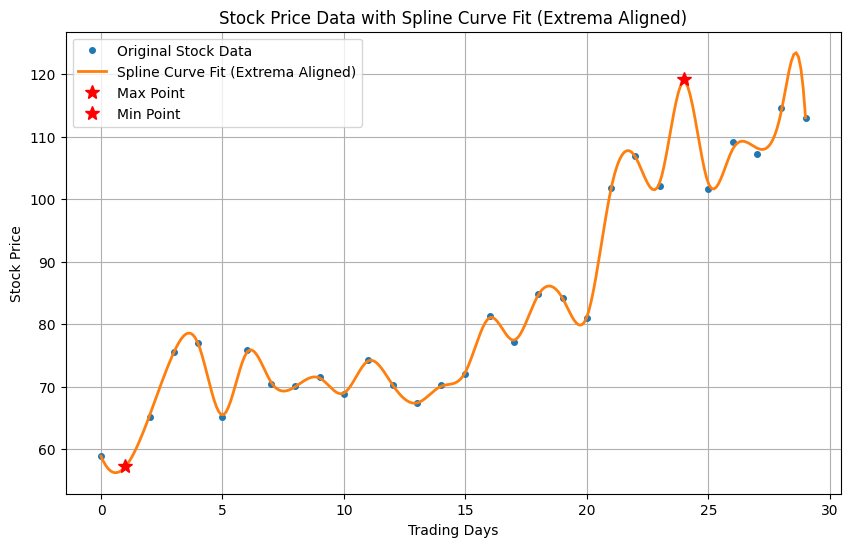

In [16]:
import numpy as np  # 导入 NumPy 库，用于数值计算
import matplotlib.pyplot as plt  # 导入 Matplotlib 库，用于绘制图表
from scipy.interpolate import UnivariateSpline  # 导入 UnivariateSpline 类，用于一元样条插值

# 1. 生成模拟股票走势数据 (与之前代码相同)
np.random.seed(0)  # 设置随机数种子，保证每次运行结果一致
x = np.arange(30)  # 生成 0 到 29 的整数数组作为交易日
y_original = 50 + 10 * np.sin(x / 3) + 2 * x + np.random.normal(0, 5, 30)  # 生成模拟股票价格数据

# 2. 找到股票走势数据中的最高点和最低点及其索引
max_y_index = np.argmax(y_original)  # 找到最高点的索引
min_y_index = np.argmin(y_original)  # 找到最低点的索引

max_x = x[max_y_index]  # 获取最高点对应的 x 值（交易日）
max_y = y_original[max_y_index]  # 获取最高点对应的 y 值（股票价格）
min_x = x[min_y_index]  # 获取最低点对应的 x 值（交易日）
min_y = y_original[min_y_index]  # 获取最低点对应的 y 值（股票价格）

# 3. 创建包含关键点的新 x 和 y 数据，用于样条曲线拟合
#    我们将原始的 x 和 y 数据，以及最高点和最低点的数据合并在一起
x_with_extrema = np.concatenate([x, [max_x, min_x]])  # 合并原始 x 数据和最高点、最低点的 x 值
y_with_extrema = np.concatenate([y_original, [max_y, min_y]])  # 合并原始 y 数据和最高点、最低点的 y 值

#    为了让样条曲线更好地拟合，我们还需要对 x_with_extrema 进行排序，确保 x 值是递增的
sort_index = np.argsort(x_with_extrema)  # 获取排序后的索引
x_with_extrema_sorted = x_with_extrema[sort_index]  # 根据排序后的索引对 x 数据进行排序
y_with_extrema_sorted = y_with_extrema[sort_index]  # 根据排序后的索引对 y 数据进行排序

# 4. 使用 UnivariateSpline 进行曲线拟合 (使用包含关键点的数据)
#    这里我们仍然使用 s=5 的平滑因子，你可以根据需要调整
spl = UnivariateSpline(x_with_extrema_sorted, y_with_extrema_sorted, s=5)  # 创建一元样条插值对象，使用平滑因子 s=5

# 5. 生成更密集的 x 值用于绘制平滑曲线 (与之前代码相同)
x_smooth = np.linspace(x.min(), x.max(), 300)  # 生成 300 个在原始 x 范围内的均匀分布的 x 值
y_spline = spl(x_smooth)  # 使用样条插值对象计算平滑的 y 值

# 6. 绘制原始数据、拟合曲线以及最高点和最低点
plt.figure(figsize=(10, 6))  # 创建一个 10x6 英寸的图表
plt.plot(x, y_original, 'o', label='Original Stock Data', markersize=4)  # 绘制原始股票数据，使用圆圈标记
plt.plot(x_smooth, y_spline, '-', label='Spline Curve Fit (Extrema Aligned)', linewidth=2)  # 绘制样条曲线拟合结果

# 绘制最高点和最低点，用红色星号标记
plt.plot(max_x, max_y, 'r*', markersize=10, label='Max Point')  # 绘制最高点，使用红色星号标记
plt.plot(min_x, min_y, 'r*', markersize=10, label='Min Point')  # 绘制最低点，使用红色星号标记

plt.xlabel('Trading Days')  # 设置 x 轴标签
plt.ylabel('Stock Price')  # 设置 y 轴标签
plt.title('Stock Price Data with Spline Curve Fit (Extrema Aligned)')  # 设置图表标题
plt.legend()  # 显示图例
plt.grid(True)  # 显示网格线
plt.show()  # 显示图表